<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 40px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Chatbot - Génératif - Agnostique
  </div> 
  
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  M2DS 2019
  </div> 
  

  <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
  Jean-baptiste Aujogue
  </div>

In [1]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import pickle
import copy
# package a installer d'abord avec anaconda
#import spacy

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# package a installer d'abord avec anaconda
import gensim
from gensim.models import KeyedVectors

#import nltk
#nltk.download()
#from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import unidecode
from unidecode import unidecode

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import time
import math
import re
import json

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device("cuda" if USE_CUDA else "cpu")

True


In [4]:
import sys
sys.path.append('C:\\Users\\Jb\\Desktop\\NLP\\chatNLP')

# 1 Training data preparation

### 1.1 Simple formatting of training dialogues

In [5]:
# -------------------- enlèvement des stopwords ---------------------------------------
def TrimWordsSentence(sentence, stopwords):
    '''Remove stopwords from a sentence'''
    resultwords = [word for word in sentence if word.lower() not in stopwords]
    return resultwords

def TrimWordsDialogue(dialogue, stopwords):
    '''Remove stopwords from user utterances in a dialogue'''
    for pair in dialogue: 
        pair[0] = TrimWordsSentence(pair[0], stopwords)
        #pair[1] = pair[1].strip()
    return dialogue

def TrimWords(dialogues, stopwords):
    '''Remove stopwords from user utterances in a list of dialogues'''
    return [TrimWordsDialogue(dialogue, stopwords) for dialogue in dialogues ]

    


# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
 
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    s = re.sub("\(", r" ( ", s)
    s = re.sub("\)", r" ) ", s)
    s = re.sub(r"\.", r" . ", s)
    s = re.sub(r",", r" , ", s)
    s = re.sub(r"!", r" ! ", s)
    s = re.sub(r":", r" : ", s)
    s = re.sub(r"-", r" - ", s)
    s = re.sub(r"'", r" ' ", s)
    s = re.sub(r";", r" ; ", s)
    s = re.sub(r' +', r' ', s).strip()
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(fichier, limite = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    def cleanS(s):
        cleans = normalizeString(s).split(' ')
        cleans = [word for word in cleans if word.strip() != '']
        return cleans
    dialogues_import = open(fichier, encoding='utf-8').read().strip().split('\n\n')
    dialogues = []
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [cleanS(s) for s in l.split('\t')]
                dialogue.append(pair)
            elif len(l.split('\t')) == 3 :
                pair = [cleanS(s) for s in l.split('\t')[:2]]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limite is not None and i == limite -1 :
            break

    return dialogues






#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar




# ----------------------- Création de la liste des dialogues--------------------
def prepareData(opt):
    '''Import dialogue from text file and apply some formatting operations,
       as described in the functions 
               - importDialogues
               - modify
               - TrimWords
               - filterDialogues
    '''
    dialogues = importDialogues(fichier = opt['fichier'], 
                                limite = opt['limite'])
    dialogues = modify(dialogues) if opt['modify'] else dialogues
    dialogues = TrimWords(dialogues, opt['stopwords']) # on enlève les stopwords de chaque question
    print(" %s dialogues ..." % len(dialogues))
    print(dialogues[0])
    if opt['filtre'] :
        #for pair in [pair for pair in pairs if not filterPair(pair)]:
        #    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
        dialogues = filterDialogues(dialogues, opt['max_length'])
        print('')
        print("... reduced to %s dialogues" % len(dialogues))

    return dialogues

In [6]:
motsVar = motVar('C:\\Users\\Jb\\Desktop\\NLP\\data\\Conversations_M2DS\\chatbot-M2-DS-Variables.txt')

Turn each dialogue of the corpus into torch variables

In [7]:
def variableFromSentence(lang, sentence, rand = 0): # sentence = [str]
    indexes=[]
    unknowns = 0
    for word in sentence:
        p = random.random()
        if word not in lang.word2index.keys() and 'UNK' in lang.word2index.keys() :
            #pass
            indexes.append(lang.word2index['UNK'])
        elif p >= rand :
            indexes.append(lang.word2index[word])
        elif p < rand :
            e = random.choice([1, 2])
            if e == 1 :  # doesn't put any word
                pass
            elif e == 2 and 'UNK' in lang.word2index.keys() :# hide word with UNK_Token
                indexes.append(lang.word2index['UNK'])
    indexes.append(lang.word2index['EOS'])                                
    result = Variable(torch.LongTensor([[i] for i in indexes]))
    return result

def variableFromDialogue(lang, dialogue, rand = 0): # sentence = [str]
    result = []
    for paire in dialogue :
        el1 = variableFromSentence(lang, paire[0], rand = rand)
        el2 = variableFromSentence(lang, paire[1], rand = 0)
        result.append([el1, el2])
    return result

def variableFromAllDialogues(lang, dialogues, rand = 0): # sentence = [str]
    result = []
    for dialogue in dialogues :
        result.append(variableFromDialogue(lang, dialogue, rand = 0))
    return result

### 1.2 Language class

In [8]:
class Lang:
    def __init__(self, name, init = 3):
        self.name = name
        if init == 0 :
            self.word2index = {}
            self.word2count = {}
            self.index2word = {}
            self.n_words = 0
        elif init == 3 :
            self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
            self.word2count = {"SOS": 0, "EOS": 0, "UNK": 0}
            self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
            self.n_words = 3

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            if word.strip() != '' :
                self.word2index[word] = self.n_words
                self.word2count[word] = 1
                self.index2word[self.n_words] = word
                self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        if type(sentence) == str :
            for word in nltk.word_tokenize(sentence): # sentence.split()
                self.addWord(word)
        elif type(sentence) == list :
            for word in sentence:
                self.addWord(word)            
            
            
    def addDescriptions(self, descriptions, lvl = 1):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for description in descriptions :
            
            # si la description est une seule ligne
            if type(description) == str :
                    try :
                        if lvl == 2 :
                            for sentence in nltk.sent_tokenize(description) :
                                self.addSentence(sentence)
                        else :
                            self.addSentence(description)
                    except IndexError:
                        print("Problem with {}".format(description))
                        
            # si la description est une liste de lignes
            elif type(description) == list :
                for line in description:
                    try :
                        self.addSentence(line)
                    except IndexError:
                        print("Problem with {}".format(line))
                              
            # sinon
            else :
                print("Problem with {}".format(description))
            
            
    def addDialogues(self, dialogues, i):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for dialogue in dialogues :
            for pair in dialogue:
                try :
                    self.addSentence(pair[i])
                except IndexError:
                    print("Problem with {}".format(pair))

In [9]:
def generateLanguages(dialogues):
    '''Generate three languages classes out of a list of dialogues :
            - input_lang containing the user's vocabulary
            - output lang containing the bot vocabulary
            - output_sentence_lang containing the bot answers as words of a vocabulary
    '''
    lang = Lang('M2DS')
    
    lang.addDialogues(dialogues, 0)
    lang.addDialogues(dialogues, 1)
    print("Mots comptés :")
    print(lang.name, lang.n_words)
    
    return lang


def ajout(dialogues, lang, i= 1):
    '''addDialogues method of the Lang class with prints.'''
    lang.addDialogues(dialogues, i)
    print(lang.name, lang.n_words)
    return lang 


def ajoutSentences(dialogues, sentences_lang, i = 1) :
    '''Add sentences as words to a given language'''
    for dialogue in dialogues :
        for pair in dialogue :
            try :
                sentences_lang.addWord(pair[i])
            except IndexError:
                print("Problem with {}".format(pair))
                
    return sentences_lang

## 1.3 Master's program dataset

In [10]:
MAX_LENGTH = 100
max_length = MAX_LENGTH
stopwords = []

Master_train =   {'fichier': 'C:\\Users\\Jb\\Desktop\\NLP\\data\\Conversations_M2DS\\Conversations_M2DS_2019_final\\ChatbotDS_Train.tsv', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'filtre' : False}

dialogues_Master = prepareData(Master_train)

Master_test  =   {'lang1': 'lang_client',
                   'lang2' : 'lang_agent',
                   'fichier': 'C:\\Users\\Jb\\Desktop\\NLP\\data\\Conversations_M2DS\\Conversations_M2DS_2019_final\\ChatbotDS_Test.tsv', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'reverse' : False,
                   'filtre' : False}

dialogues_Master_test = prepareData(Master_test)

 100000 dialogues ...
[[['quel', 'est', 'l', "'", 'enseignant', 'de', 'l', "'", 'ue', 'de', 'pgm', '?'], ['l', "'", 'enseignant', 'de', 'modeles', 'graphiques', 'probabilistes', 'est', 'pr', '.', 'profpgm']], [['ca', 'va', 'merci', 'j', "'", 'ai', 'besoin', 'de', 'rien'], ['d', "'", 'accord', ',', 'j', "'", 'espere', 'avoir', 'correctement', 'repondu', 'a', 'vos', 'questions', '.']], [['que', 'faut', 'il', 'lire', 'en', 'statistique', 'inferentielle', '?'], ['vous', 'devriez', 'prendre', 'contact', 'avec', 'l', "'", 'enseignant', 'de', 'l', "'", 'ue', 'et', 'lui', 'demander']], [['je', 'viens', 'de', 'l', "'", 'etranger'], ['d', "'", 'accord', ',', 'comment', 'puis', '-', 'je', 'vous', 'aider', '?']], [['quel', 'est', 'le', 'cout', 'du', 'master', '?'], ['vous', 'devriez', 'poser', 'la', 'question', 'au', 'service', 'de', 'scolarite', '.']], [['c', "'", 'est', 'quand', 'la', 'fin', 'des', 'cours', '?'], ['aux', 'alentours', 'du', 'mois', 'de', 'mars', '.']], [['ca', 'va', 'merci', 'j',

In [11]:
lang_M2DS = generateLanguages(dialogues_Master)

Mots comptés :
M2DS 1291


In [12]:
# compute ONCE
#with open(r'C:\\Users\\Jb\\Desktop\\NLP\\saves\\lang_M2DS_2019_final.file', 'wb') as fileObject :
#    pickle.dump(lang_M2DS, fileObject)

# 1062 / 1272 / 1291 mots comptés

In [13]:
def importLang(name):
    with open('C:\\Users\\Jb\\Desktop\\NLP\\saves\\lang\\'+name+'.file', 'rb') as fil :
        lang = pickle.load(fil)
    return lang

In [14]:
#lang_M2DS = importLang('lang_M2DS_2019_final') # 1062 / 1272 / 1291

# 2 Word Embedding

## 2.1 Models

In [15]:
from chatNLP.models.Word_Embedding import CBOW, SkipGram, WordEmbeddingTrainer

**Cbow**

In [17]:
cbow = CBOW(device,
            lang = lang_M2DS,
            context_size = 5,
            embedding_dim = 100,
            hidden_dim = 100)
cbow = cbow.to(device)

In [18]:
cbow.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_cbow.pth'))

**SkipGram**

In [16]:
skipgram = SkipGram(device, 
                    lang = lang_M2DS, 
                    context_size = 5, 
                    embedding_dim = 150, 
                    hidden_dim = 150)
skipgram = skipgram.to(device)

In [17]:
skipgram.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_skipgram_150.pth'))

In [44]:
word_embedding_trainer = WordEmbeddingTrainer(device = device)

In [45]:
def flatten(description) :
    '''Baisse le nombre de niveaux de 1 dans la description'''
    flatten = []
    for line in description :
        flatten += line
    return flatten


def generateNgrams(descriptions, context_size = 5, word_first = True) :
    '''descriptions = [[str]]'''
    data = []
    for description in descriptions :
        lines = flatten(description)
        line =  flatten(lines)
        line = ['SOS' for i in range(context_size)] + line + ['EOS' for i in range(context_size)] 
        for i in range(context_size, len(line) - context_size):
            context = line[i-context_size : i] + line[i+1 : i+context_size+1]
            target = [line[i]]
            if word_first :
                data.append((target, context))
            else :
                data.append((context, target))
    return data

In [41]:
#Ngrams_cbow = generateNgrams(dialogues_Master, context_size = 5, word_first = False)

#word_embedding_trainer.train(cbow, Ngrams_cbow, n_iters = 80000, learning_rate=0.01)
#word_embedding_trainer.train(cbow, Ngrams_cbow, n_iters = 50000, learning_rate=0.0025)

#torch.save(cbow.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\M2DS_cbow.pth')

In [46]:
for alpha in [0.01, 0.005, 0.0025, 0.001] :
    for i in range(20) :
        Ngrams = generateNgrams(dialogues_Master[5000*i:5000*(i+1)], context_size = 5, word_first = True)
        word_embedding_trainer.train(skipgram, Ngrams, n_iters = 10000, learning_rate=alpha)

0m 3s (- 5m 56s) (100 1%) 7.1421 9.96
0m 4s (- 3m 39s) (200 2%) 7.0518 9.86
0m 5s (- 2m 42s) (300 3%) 6.9536 9.63
0m 5s (- 2m 14s) (400 4%) 6.8100 9.56
0m 6s (- 1m 56s) (500 5%) 6.7338 9.58
0m 6s (- 1m 45s) (600 6%) 6.6897 9.69
0m 7s (- 1m 36s) (700 7%) 6.5354 9.59
0m 7s (- 1m 30s) (800 8%) 6.4890 9.58
0m 8s (- 1m 25s) (900 9%) 6.3640 9.61
0m 9s (- 1m 21s) (1000 10%) 6.3139 9.49
0m 9s (- 1m 17s) (1100 11%) 6.2259 9.58
0m 10s (- 1m 14s) (1200 12%) 6.1405 9.63
0m 10s (- 1m 11s) (1300 13%) 6.1516 9.66
0m 11s (- 1m 9s) (1400 14%) 6.0176 9.49
0m 11s (- 1m 7s) (1500 15%) 6.0453 9.62
0m 12s (- 1m 6s) (1600 16%) 6.0008 9.53
0m 13s (- 1m 5s) (1700 17%) 5.9596 9.57
0m 14s (- 1m 4s) (1800 18%) 5.9118 9.52
0m 14s (- 1m 2s) (1900 19%) 5.8928 9.45
0m 15s (- 1m 1s) (2000 20%) 5.9254 9.54
0m 15s (- 0m 59s) (2100 21%) 5.7867 9.60
0m 16s (- 0m 58s) (2200 22%) 5.7707 9.42
0m 17s (- 0m 57s) (2300 23%) 5.7903 9.58
0m 17s (- 0m 55s) (2400 24%) 5.7503 9.52
0m 18s (- 0m 54s) (2500 25%) 5.8686 9.53
0m 18s (- 0

0m 2s (- 0m 54s) (400 4%) 4.9196 8.58
0m 2s (- 0m 53s) (500 5%) 4.6024 8.16
0m 3s (- 0m 52s) (600 6%) 4.7820 8.42
0m 3s (- 0m 51s) (700 7%) 4.6600 8.27
0m 4s (- 0m 51s) (800 8%) 4.8596 8.65
0m 4s (- 0m 50s) (900 9%) 4.8228 8.49
0m 5s (- 0m 49s) (1000 10%) 4.8548 8.55
0m 6s (- 0m 49s) (1100 11%) 4.8292 8.55
0m 6s (- 0m 48s) (1200 12%) 4.5972 8.06
0m 7s (- 0m 48s) (1300 13%) 4.5457 8.12
0m 7s (- 0m 47s) (1400 14%) 4.5056 8.15
0m 8s (- 0m 47s) (1500 15%) 4.7076 8.39
0m 8s (- 0m 46s) (1600 16%) 4.6107 8.19
0m 9s (- 0m 45s) (1700 17%) 4.6430 8.40
0m 9s (- 0m 45s) (1800 18%) 4.7430 8.39
0m 10s (- 0m 44s) (1900 19%) 4.5034 8.02
0m 11s (- 0m 44s) (2000 20%) 4.7155 8.38
0m 11s (- 0m 43s) (2100 21%) 4.7965 8.51
0m 12s (- 0m 43s) (2200 22%) 4.7896 8.45
0m 12s (- 0m 42s) (2300 23%) 4.7371 8.34
0m 13s (- 0m 41s) (2400 24%) 4.5288 7.95
0m 13s (- 0m 41s) (2500 25%) 4.3698 7.86
0m 14s (- 0m 40s) (2600 26%) 4.6316 8.23
0m 14s (- 0m 40s) (2700 27%) 4.8240 8.27
0m 15s (- 0m 39s) (2800 28%) 5.0473 8.69
0m

0m 3s (- 0m 51s) (700 7%) 4.4696 7.95
0m 4s (- 0m 50s) (800 8%) 4.3319 8.09
0m 4s (- 0m 50s) (900 9%) 4.0972 7.52
0m 5s (- 0m 49s) (1000 10%) 4.2907 7.79
0m 6s (- 0m 48s) (1100 11%) 4.2439 7.84
0m 6s (- 0m 48s) (1200 12%) 4.4728 8.14
0m 7s (- 0m 47s) (1300 13%) 4.4021 8.20
0m 7s (- 0m 47s) (1400 14%) 4.5195 8.33
0m 8s (- 0m 46s) (1500 15%) 4.3009 7.96
0m 8s (- 0m 46s) (1600 16%) 4.4307 7.94
0m 9s (- 0m 45s) (1700 17%) 4.4361 7.93
0m 9s (- 0m 45s) (1800 18%) 4.3932 7.99
0m 10s (- 0m 44s) (1900 19%) 4.1172 7.61
0m 10s (- 0m 43s) (2000 20%) 4.4533 8.06
0m 11s (- 0m 43s) (2100 21%) 4.4038 8.24
0m 12s (- 0m 42s) (2200 22%) 4.1490 7.91
0m 12s (- 0m 42s) (2300 23%) 4.3474 7.88
0m 13s (- 0m 41s) (2400 24%) 4.3788 8.00
0m 13s (- 0m 41s) (2500 25%) 4.2575 7.89
0m 14s (- 0m 40s) (2600 26%) 4.3581 7.97
0m 14s (- 0m 40s) (2700 27%) 3.9932 7.10
0m 15s (- 0m 39s) (2800 28%) 4.4074 8.02
0m 15s (- 0m 38s) (2900 28%) 4.6812 8.20
0m 16s (- 0m 38s) (3000 30%) 4.4435 8.21
0m 17s (- 0m 37s) (3100 31%) 4.595

0m 5s (- 0m 49s) (1000 10%) 4.1040 7.55
0m 6s (- 0m 49s) (1100 11%) 4.2515 7.75
0m 6s (- 0m 48s) (1200 12%) 4.2153 7.90
0m 7s (- 0m 47s) (1300 13%) 4.1270 7.99
0m 7s (- 0m 47s) (1400 14%) 4.1501 7.99
0m 8s (- 0m 46s) (1500 15%) 4.1511 7.72
0m 8s (- 0m 46s) (1600 16%) 4.0448 7.57
0m 9s (- 0m 45s) (1700 17%) 4.2624 7.84
0m 9s (- 0m 45s) (1800 18%) 4.0824 7.75
0m 10s (- 0m 44s) (1900 19%) 4.2033 7.66
0m 11s (- 0m 44s) (2000 20%) 4.0520 7.81
0m 11s (- 0m 43s) (2100 21%) 4.0266 7.70
0m 12s (- 0m 42s) (2200 22%) 4.3735 7.98
0m 12s (- 0m 42s) (2300 23%) 3.8977 7.44
0m 13s (- 0m 41s) (2400 24%) 3.8746 7.38
0m 13s (- 0m 41s) (2500 25%) 4.1205 8.00
0m 14s (- 0m 40s) (2600 26%) 4.1358 7.93
0m 14s (- 0m 40s) (2700 27%) 4.3743 7.97
0m 15s (- 0m 39s) (2800 28%) 3.9700 7.30
0m 15s (- 0m 39s) (2900 28%) 4.4302 8.26
0m 16s (- 0m 38s) (3000 30%) 4.1325 7.98
0m 17s (- 0m 37s) (3100 31%) 4.1241 8.05
0m 17s (- 0m 37s) (3200 32%) 4.0465 7.67
0m 18s (- 0m 36s) (3300 33%) 4.2065 7.93
0m 18s (- 0m 36s) (3400 3

0m 7s (- 0m 47s) (1300 13%) 4.1080 7.88
0m 7s (- 0m 47s) (1400 14%) 3.9665 7.81
0m 8s (- 0m 46s) (1500 15%) 3.9683 7.60
0m 8s (- 0m 46s) (1600 16%) 3.9390 7.67
0m 9s (- 0m 45s) (1700 17%) 3.8526 7.39
0m 9s (- 0m 45s) (1800 18%) 3.9965 7.82
0m 10s (- 0m 44s) (1900 19%) 3.6515 7.05
0m 11s (- 0m 44s) (2000 20%) 3.9297 7.58
0m 11s (- 0m 43s) (2100 21%) 4.0343 7.68
0m 12s (- 0m 42s) (2200 22%) 4.0123 7.56
0m 12s (- 0m 42s) (2300 23%) 4.0394 7.81
0m 13s (- 0m 41s) (2400 24%) 4.0550 7.74
0m 13s (- 0m 41s) (2500 25%) 4.0715 7.81
0m 14s (- 0m 40s) (2600 26%) 4.1169 7.50
0m 14s (- 0m 40s) (2700 27%) 3.9812 7.76
0m 15s (- 0m 39s) (2800 28%) 3.7462 6.98
0m 15s (- 0m 39s) (2900 28%) 3.6765 7.12
0m 16s (- 0m 38s) (3000 30%) 4.1800 7.80
0m 17s (- 0m 37s) (3100 31%) 4.1936 8.01
0m 17s (- 0m 37s) (3200 32%) 3.9781 7.35
0m 18s (- 0m 36s) (3300 33%) 4.0579 7.68
0m 18s (- 0m 36s) (3400 34%) 4.1410 8.02
0m 19s (- 0m 35s) (3500 35%) 4.2255 8.05
0m 19s (- 0m 35s) (3600 36%) 3.9984 7.82
0m 20s (- 0m 34s) (370

0m 9s (- 0m 48s) (1600 16%) 3.9823 7.46
0m 9s (- 0m 48s) (1700 17%) 3.8917 7.90
0m 10s (- 0m 47s) (1800 18%) 3.8452 7.39
0m 10s (- 0m 46s) (1900 19%) 3.7986 7.55
0m 11s (- 0m 46s) (2000 20%) 3.8061 7.54
0m 12s (- 0m 45s) (2100 21%) 4.0771 7.80
0m 12s (- 0m 44s) (2200 22%) 4.0727 7.88
0m 13s (- 0m 44s) (2300 23%) 3.8827 7.43
0m 13s (- 0m 43s) (2400 24%) 4.0900 7.69
0m 14s (- 0m 42s) (2500 25%) 4.0715 7.75
0m 14s (- 0m 42s) (2600 26%) 4.1044 7.91
0m 15s (- 0m 41s) (2700 27%) 3.8362 7.07
0m 15s (- 0m 41s) (2800 28%) 3.7537 7.68
0m 16s (- 0m 40s) (2900 28%) 3.8639 7.74
0m 17s (- 0m 39s) (3000 30%) 3.9890 7.82
0m 17s (- 0m 39s) (3100 31%) 4.0551 7.51
0m 18s (- 0m 38s) (3200 32%) 4.0075 7.91
0m 18s (- 0m 38s) (3300 33%) 3.9324 7.57
0m 19s (- 0m 37s) (3400 34%) 3.9406 7.66
0m 19s (- 0m 36s) (3500 35%) 3.8946 7.61
0m 20s (- 0m 36s) (3600 36%) 3.9130 7.48
0m 21s (- 0m 35s) (3700 37%) 3.7665 7.52
0m 21s (- 0m 35s) (3800 38%) 3.7043 7.56
0m 22s (- 0m 34s) (3900 39%) 3.6995 7.26
0m 22s (- 0m 34s) 

0m 17s (- 1m 16s) (1900 19%) 3.8661 7.40
0m 18s (- 1m 13s) (2000 20%) 4.0291 7.99
0m 19s (- 1m 11s) (2100 21%) 3.9058 7.72
0m 19s (- 1m 9s) (2200 22%) 3.9163 7.90
0m 20s (- 1m 7s) (2300 23%) 3.7042 7.56
0m 20s (- 1m 5s) (2400 24%) 3.5601 6.75
0m 21s (- 1m 4s) (2500 25%) 4.0052 7.76
0m 21s (- 1m 2s) (2600 26%) 3.5995 7.24
0m 22s (- 1m 0s) (2700 27%) 3.6127 7.30
0m 23s (- 0m 59s) (2800 28%) 3.6848 7.40
0m 23s (- 0m 58s) (2900 28%) 3.7690 7.65
0m 24s (- 0m 57s) (3000 30%) 3.7106 7.21
0m 25s (- 0m 55s) (3100 31%) 3.7417 7.48
0m 25s (- 0m 54s) (3200 32%) 3.9738 7.84
0m 26s (- 0m 53s) (3300 33%) 3.5900 7.06
0m 26s (- 0m 52s) (3400 34%) 3.6486 7.52
0m 27s (- 0m 51s) (3500 35%) 3.8847 7.55
0m 28s (- 0m 49s) (3600 36%) 3.7462 7.24
0m 28s (- 0m 48s) (3700 37%) 3.7497 7.41
0m 29s (- 0m 47s) (3800 38%) 3.8707 7.74
0m 29s (- 0m 46s) (3900 39%) 3.8624 7.45
0m 30s (- 0m 45s) (4000 40%) 3.6943 7.20
0m 30s (- 0m 44s) (4100 41%) 3.7420 7.69
0m 31s (- 0m 43s) (4200 42%) 3.9364 7.57
0m 32s (- 0m 42s) (430

0m 12s (- 0m 43s) (2200 22%) 3.5875 7.25
0m 12s (- 0m 42s) (2300 23%) 3.5388 6.89
0m 13s (- 0m 42s) (2400 24%) 3.7011 7.48
0m 13s (- 0m 41s) (2500 25%) 3.8350 7.72
0m 14s (- 0m 41s) (2600 26%) 3.7637 7.39
0m 14s (- 0m 40s) (2700 27%) 3.6867 7.41
0m 15s (- 0m 39s) (2800 28%) 3.5462 7.31
0m 16s (- 0m 39s) (2900 28%) 3.7109 7.40
0m 16s (- 0m 38s) (3000 30%) 3.7312 7.36
0m 17s (- 0m 38s) (3100 31%) 3.5075 7.31
0m 17s (- 0m 37s) (3200 32%) 3.7412 7.30
0m 18s (- 0m 37s) (3300 33%) 4.0014 8.07
0m 18s (- 0m 36s) (3400 34%) 3.7308 7.35
0m 19s (- 0m 36s) (3500 35%) 3.9182 7.76
0m 20s (- 0m 35s) (3600 36%) 3.6780 7.22
0m 20s (- 0m 35s) (3700 37%) 3.9245 7.85
0m 21s (- 0m 34s) (3800 38%) 3.6274 7.63
0m 21s (- 0m 34s) (3900 39%) 3.5574 7.18
0m 22s (- 0m 33s) (4000 40%) 3.9506 7.78
0m 22s (- 0m 32s) (4100 41%) 3.5141 7.20
0m 23s (- 0m 32s) (4200 42%) 3.5791 7.23
0m 24s (- 0m 31s) (4300 43%) 3.6311 7.43
0m 24s (- 0m 31s) (4400 44%) 3.5892 7.86
0m 25s (- 0m 30s) (4500 45%) 3.7810 7.49
0m 25s (- 0m 30s

0m 14s (- 0m 44s) (2500 25%) 3.7492 7.75
0m 15s (- 0m 43s) (2600 26%) 3.7467 7.57
0m 15s (- 0m 42s) (2700 27%) 3.6099 7.22
0m 16s (- 0m 42s) (2800 28%) 3.6754 7.13
0m 16s (- 0m 41s) (2900 28%) 3.7710 7.55
0m 17s (- 0m 40s) (3000 30%) 3.9006 7.77
0m 18s (- 0m 40s) (3100 31%) 3.9404 7.70
0m 18s (- 0m 39s) (3200 32%) 3.5321 7.16
0m 19s (- 0m 39s) (3300 33%) 3.7360 7.61
0m 19s (- 0m 38s) (3400 34%) 3.4509 7.29
0m 20s (- 0m 37s) (3500 35%) 3.4218 7.03
0m 20s (- 0m 37s) (3600 36%) 4.0393 7.96
0m 21s (- 0m 36s) (3700 37%) 3.4522 7.27
0m 22s (- 0m 36s) (3800 38%) 3.5374 7.21
0m 22s (- 0m 35s) (3900 39%) 3.6509 7.49
0m 23s (- 0m 34s) (4000 40%) 3.6124 7.43
0m 23s (- 0m 34s) (4100 41%) 3.6512 7.49
0m 24s (- 0m 33s) (4200 42%) 3.5843 7.50
0m 24s (- 0m 33s) (4300 43%) 3.8286 7.69
0m 25s (- 0m 32s) (4400 44%) 3.8497 7.88
0m 26s (- 0m 31s) (4500 45%) 3.6854 7.56
0m 26s (- 0m 31s) (4600 46%) 3.8035 7.56
0m 27s (- 0m 30s) (4700 47%) 3.6487 7.37
0m 27s (- 0m 30s) (4800 48%) 3.7665 7.97
0m 28s (- 0m 29s

0m 15s (- 0m 40s) (2800 28%) 3.7323 7.52
0m 16s (- 0m 39s) (2900 28%) 3.5400 7.38
0m 16s (- 0m 39s) (3000 30%) 3.5978 7.48
0m 17s (- 0m 38s) (3100 31%) 3.4672 7.08
0m 17s (- 0m 37s) (3200 32%) 3.6066 7.29
0m 18s (- 0m 37s) (3300 33%) 3.5721 7.50
0m 18s (- 0m 36s) (3400 34%) 3.2757 6.85
0m 19s (- 0m 36s) (3500 35%) 3.5182 7.22
0m 20s (- 0m 35s) (3600 36%) 3.3937 7.02
0m 20s (- 0m 35s) (3700 37%) 3.6598 7.50
0m 21s (- 0m 34s) (3800 38%) 3.2941 7.12
0m 21s (- 0m 33s) (3900 39%) 3.7613 7.63
0m 22s (- 0m 33s) (4000 40%) 3.7312 7.60
0m 22s (- 0m 32s) (4100 41%) 3.7195 7.44
0m 23s (- 0m 32s) (4200 42%) 3.7279 7.62
0m 23s (- 0m 31s) (4300 43%) 3.4996 6.74
0m 24s (- 0m 31s) (4400 44%) 3.5421 7.27
0m 24s (- 0m 30s) (4500 45%) 3.4143 6.86
0m 25s (- 0m 29s) (4600 46%) 3.8010 7.74
0m 26s (- 0m 29s) (4700 47%) 3.7323 7.52
0m 26s (- 0m 28s) (4800 48%) 3.6087 7.40
0m 27s (- 0m 28s) (4900 49%) 3.5839 7.51
0m 27s (- 0m 27s) (5000 50%) 3.5580 7.41
0m 28s (- 0m 27s) (5100 51%) 3.4129 7.16
0m 28s (- 0m 26s

0m 17s (- 0m 38s) (3100 31%) 3.6640 7.48
0m 17s (- 0m 37s) (3200 32%) 3.3087 7.25
0m 18s (- 0m 36s) (3300 33%) 3.6123 7.44
0m 18s (- 0m 36s) (3400 34%) 3.3858 7.03
0m 19s (- 0m 35s) (3500 35%) 3.2898 6.91
0m 19s (- 0m 35s) (3600 36%) 3.2937 6.93
0m 20s (- 0m 34s) (3700 37%) 3.6018 7.37
0m 20s (- 0m 34s) (3800 38%) 3.5858 7.50
0m 21s (- 0m 33s) (3900 39%) 3.5336 7.07
0m 22s (- 0m 33s) (4000 40%) 3.4719 7.01
0m 22s (- 0m 32s) (4100 41%) 3.6136 7.61
0m 23s (- 0m 31s) (4200 42%) 3.4779 7.16
0m 23s (- 0m 31s) (4300 43%) 3.4473 7.26
0m 24s (- 0m 30s) (4400 44%) 3.4471 7.30
0m 24s (- 0m 30s) (4500 45%) 3.8528 7.90
0m 25s (- 0m 29s) (4600 46%) 3.4606 7.34
0m 25s (- 0m 29s) (4700 47%) 3.4099 6.95
0m 26s (- 0m 28s) (4800 48%) 3.6104 7.56
0m 26s (- 0m 28s) (4900 49%) 3.4266 7.50
0m 27s (- 0m 27s) (5000 50%) 3.4617 6.99
0m 28s (- 0m 26s) (5100 51%) 3.4309 7.03
0m 28s (- 0m 26s) (5200 52%) 3.4853 7.50
0m 29s (- 0m 25s) (5300 53%) 3.7471 7.68
0m 29s (- 0m 25s) (5400 54%) 3.3870 7.28
0m 30s (- 0m 24s

0m 19s (- 0m 36s) (3400 34%) 3.4526 7.59
0m 19s (- 0m 36s) (3500 35%) 3.7745 7.87
0m 20s (- 0m 35s) (3600 36%) 3.0282 6.91
0m 20s (- 0m 35s) (3700 37%) 3.6345 7.21
0m 21s (- 0m 34s) (3800 38%) 3.3614 7.15
0m 21s (- 0m 34s) (3900 39%) 3.6159 7.17
0m 22s (- 0m 33s) (4000 40%) 3.7335 7.73
0m 22s (- 0m 32s) (4100 41%) 3.5801 7.54
0m 23s (- 0m 32s) (4200 42%) 3.7160 7.93
0m 23s (- 0m 31s) (4300 43%) 3.5336 7.30
0m 24s (- 0m 31s) (4400 44%) 3.5629 7.23
0m 25s (- 0m 30s) (4500 45%) 3.4829 7.46
0m 25s (- 0m 30s) (4600 46%) 3.2506 6.89
0m 26s (- 0m 29s) (4700 47%) 3.6111 7.58
0m 26s (- 0m 29s) (4800 48%) 3.3114 7.13
0m 27s (- 0m 28s) (4900 49%) 3.6002 7.32
0m 27s (- 0m 27s) (5000 50%) 3.7750 7.42
0m 28s (- 0m 27s) (5100 51%) 3.5889 7.21
0m 28s (- 0m 26s) (5200 52%) 3.5808 7.58
0m 29s (- 0m 26s) (5300 53%) 3.5327 7.34
0m 30s (- 0m 25s) (5400 54%) 3.3960 7.17
0m 30s (- 0m 25s) (5500 55%) 3.3046 7.19
0m 31s (- 0m 24s) (5600 56%) 3.4001 7.19
0m 31s (- 0m 23s) (5700 56%) 3.5363 7.41
0m 32s (- 0m 23s

0m 20s (- 0m 34s) (3700 37%) 3.5080 7.40
0m 20s (- 0m 34s) (3800 38%) 3.4305 7.36
0m 21s (- 0m 33s) (3900 39%) 3.6068 7.42
0m 22s (- 0m 33s) (4000 40%) 3.3358 6.94
0m 22s (- 0m 32s) (4100 41%) 3.4863 7.52
0m 23s (- 0m 31s) (4200 42%) 3.6584 7.58
0m 23s (- 0m 31s) (4300 43%) 3.3405 6.88
0m 24s (- 0m 30s) (4400 44%) 3.5337 7.60
0m 24s (- 0m 30s) (4500 45%) 3.4313 7.17
0m 25s (- 0m 29s) (4600 46%) 3.3638 7.04
0m 25s (- 0m 29s) (4700 47%) 3.5876 7.38
0m 26s (- 0m 28s) (4800 48%) 3.4854 7.61
0m 27s (- 0m 28s) (4900 49%) 3.3829 6.97
0m 27s (- 0m 27s) (5000 50%) 3.5078 7.57
0m 28s (- 0m 27s) (5100 51%) 3.4896 7.13
0m 28s (- 0m 26s) (5200 52%) 3.4518 7.49
0m 29s (- 0m 25s) (5300 53%) 3.3943 7.20
0m 29s (- 0m 25s) (5400 54%) 3.3275 7.38
0m 30s (- 0m 24s) (5500 55%) 3.6634 7.83
0m 30s (- 0m 24s) (5600 56%) 3.6109 7.56
0m 31s (- 0m 23s) (5700 56%) 3.3542 6.98
0m 31s (- 0m 23s) (5800 57%) 3.4406 7.21
0m 32s (- 0m 22s) (5900 59%) 3.6443 7.61
0m 33s (- 0m 22s) (6000 60%) 3.4946 7.26
0m 33s (- 0m 21s

0m 22s (- 0m 33s) (4000 40%) 3.5048 7.53
0m 22s (- 0m 32s) (4100 41%) 3.3170 7.33
0m 23s (- 0m 32s) (4200 42%) 3.5453 7.43
0m 23s (- 0m 31s) (4300 43%) 3.4792 7.17
0m 24s (- 0m 30s) (4400 44%) 3.4449 7.22
0m 24s (- 0m 30s) (4500 45%) 3.4338 7.15
0m 25s (- 0m 29s) (4600 46%) 3.5967 7.39
0m 25s (- 0m 29s) (4700 47%) 3.6012 7.63
0m 26s (- 0m 28s) (4800 48%) 3.2881 6.83
0m 27s (- 0m 28s) (4900 49%) 3.4955 7.21
0m 27s (- 0m 27s) (5000 50%) 3.4112 7.43
0m 28s (- 0m 27s) (5100 51%) 3.6252 7.60
0m 28s (- 0m 26s) (5200 52%) 3.4721 7.45
0m 29s (- 0m 25s) (5300 53%) 3.4061 7.08
0m 29s (- 0m 25s) (5400 54%) 3.5409 7.60
0m 30s (- 0m 24s) (5500 55%) 3.3169 7.28
0m 30s (- 0m 24s) (5600 56%) 3.5051 7.55
0m 31s (- 0m 23s) (5700 56%) 3.2436 6.69
0m 32s (- 0m 23s) (5800 57%) 3.3086 7.11
0m 32s (- 0m 22s) (5900 59%) 3.3667 7.10
0m 33s (- 0m 22s) (6000 60%) 3.6812 7.53
0m 33s (- 0m 21s) (6100 61%) 3.4201 7.41
0m 34s (- 0m 21s) (6200 62%) 3.2837 7.15
0m 34s (- 0m 20s) (6300 63%) 3.7829 7.69
0m 35s (- 0m 20s

0m 24s (- 0m 32s) (4300 43%) 3.3068 7.07
0m 25s (- 0m 31s) (4400 44%) 3.1805 6.92
0m 25s (- 0m 31s) (4500 45%) 3.6253 7.71
0m 26s (- 0m 30s) (4600 46%) 3.5127 7.12
0m 26s (- 0m 30s) (4700 47%) 3.4769 7.30
0m 27s (- 0m 29s) (4800 48%) 3.4591 7.10
0m 27s (- 0m 29s) (4900 49%) 3.4845 7.24
0m 28s (- 0m 28s) (5000 50%) 3.4217 7.29
0m 28s (- 0m 27s) (5100 51%) 3.4771 7.15
0m 29s (- 0m 27s) (5200 52%) 3.4528 7.19
0m 30s (- 0m 26s) (5300 53%) 3.2935 7.28
0m 30s (- 0m 26s) (5400 54%) 3.5586 7.67
0m 31s (- 0m 25s) (5500 55%) 3.5269 7.60
0m 31s (- 0m 25s) (5600 56%) 3.2283 7.00
0m 32s (- 0m 24s) (5700 56%) 3.6208 7.39
0m 32s (- 0m 23s) (5800 57%) 3.1787 6.82
0m 33s (- 0m 23s) (5900 59%) 3.4357 7.44
0m 34s (- 0m 22s) (6000 60%) 3.3061 7.00
0m 34s (- 0m 22s) (6100 61%) 3.5891 7.33
0m 35s (- 0m 21s) (6200 62%) 3.4066 7.24
0m 35s (- 0m 21s) (6300 63%) 3.3008 7.07
0m 36s (- 0m 20s) (6400 64%) 3.4325 7.59
0m 36s (- 0m 19s) (6500 65%) 3.4309 7.22
0m 37s (- 0m 19s) (6600 66%) 3.3597 7.39
0m 38s (- 0m 18s

0m 25s (- 0m 30s) (4600 46%) 3.4712 7.35
0m 26s (- 0m 29s) (4700 47%) 3.3073 6.90
0m 26s (- 0m 28s) (4800 48%) 3.4341 7.01
0m 27s (- 0m 28s) (4900 49%) 3.3651 7.49
0m 27s (- 0m 27s) (5000 50%) 3.1901 7.14
0m 28s (- 0m 27s) (5100 51%) 3.3663 7.17
0m 28s (- 0m 26s) (5200 52%) 3.4414 7.47
0m 29s (- 0m 26s) (5300 53%) 3.2424 7.23
0m 30s (- 0m 25s) (5400 54%) 3.3317 7.27
0m 30s (- 0m 25s) (5500 55%) 3.6002 7.51
0m 31s (- 0m 24s) (5600 56%) 3.5098 7.54
0m 31s (- 0m 23s) (5700 56%) 3.2994 6.80
0m 32s (- 0m 23s) (5800 57%) 3.6912 7.65
0m 32s (- 0m 22s) (5900 59%) 3.4914 7.42
0m 33s (- 0m 22s) (6000 60%) 3.1825 7.11
0m 33s (- 0m 21s) (6100 61%) 3.2200 7.02
0m 34s (- 0m 21s) (6200 62%) 3.4323 7.28
0m 34s (- 0m 20s) (6300 63%) 3.4492 7.69
0m 35s (- 0m 19s) (6400 64%) 3.4875 7.22
0m 36s (- 0m 19s) (6500 65%) 3.5604 7.47
0m 36s (- 0m 18s) (6600 66%) 3.6347 7.59
0m 37s (- 0m 18s) (6700 67%) 3.1652 6.76
0m 37s (- 0m 17s) (6800 68%) 3.5743 7.39
0m 38s (- 0m 17s) (6900 69%) 3.3939 7.36
0m 38s (- 0m 16s

0m 26s (- 0m 28s) (4900 49%) 3.2644 6.94
0m 27s (- 0m 27s) (5000 50%) 3.2887 7.18
0m 28s (- 0m 26s) (5100 51%) 3.4046 7.27
0m 28s (- 0m 26s) (5200 52%) 3.3724 7.59
0m 29s (- 0m 25s) (5300 53%) 3.4993 7.55
0m 29s (- 0m 25s) (5400 54%) 3.5089 7.36
0m 30s (- 0m 24s) (5500 55%) 3.6501 7.77
0m 30s (- 0m 24s) (5600 56%) 3.4129 7.39
0m 31s (- 0m 23s) (5700 56%) 3.4304 7.14
0m 31s (- 0m 23s) (5800 57%) 3.2075 6.83
0m 32s (- 0m 22s) (5900 59%) 3.3658 7.18
0m 33s (- 0m 22s) (6000 60%) 3.3784 7.13
0m 33s (- 0m 21s) (6100 61%) 3.4723 7.38
0m 34s (- 0m 20s) (6200 62%) 3.2999 7.27
0m 34s (- 0m 20s) (6300 63%) 3.6317 7.24
0m 35s (- 0m 19s) (6400 64%) 3.2709 7.26
0m 35s (- 0m 19s) (6500 65%) 3.3699 7.07
0m 36s (- 0m 18s) (6600 66%) 3.4580 7.53
0m 36s (- 0m 18s) (6700 67%) 3.3371 6.67
0m 37s (- 0m 17s) (6800 68%) 3.1505 6.59
0m 37s (- 0m 17s) (6900 69%) 3.4922 7.75
0m 38s (- 0m 16s) (7000 70%) 3.1028 6.74
0m 39s (- 0m 15s) (7100 71%) 3.3764 7.45
0m 39s (- 0m 15s) (7200 72%) 3.3437 6.97
0m 40s (- 0m 14s

0m 28s (- 0m 26s) (5200 52%) 3.5933 7.48
0m 29s (- 0m 25s) (5300 53%) 3.4946 7.83
0m 29s (- 0m 25s) (5400 54%) 3.2240 7.07
0m 30s (- 0m 24s) (5500 55%) 3.4335 7.35
0m 30s (- 0m 24s) (5600 56%) 3.5710 7.37
0m 31s (- 0m 23s) (5700 56%) 3.2096 7.07
0m 31s (- 0m 23s) (5800 57%) 3.3418 7.40
0m 32s (- 0m 22s) (5900 59%) 3.4798 7.39
0m 33s (- 0m 22s) (6000 60%) 3.1085 6.79
0m 33s (- 0m 21s) (6100 61%) 3.4110 7.23
0m 34s (- 0m 20s) (6200 62%) 3.1688 7.13
0m 34s (- 0m 20s) (6300 63%) 3.5405 7.43
0m 35s (- 0m 19s) (6400 64%) 3.3570 7.30
0m 35s (- 0m 19s) (6500 65%) 3.6873 7.63
0m 36s (- 0m 18s) (6600 66%) 3.6842 8.08
0m 36s (- 0m 18s) (6700 67%) 3.2489 7.34
0m 37s (- 0m 17s) (6800 68%) 3.3233 7.06
0m 38s (- 0m 17s) (6900 69%) 3.5712 7.55
0m 38s (- 0m 16s) (7000 70%) 3.4529 7.46
0m 39s (- 0m 15s) (7100 71%) 3.2770 7.06
0m 39s (- 0m 15s) (7200 72%) 3.1599 7.00
0m 40s (- 0m 14s) (7300 73%) 3.3290 7.16
0m 40s (- 0m 14s) (7400 74%) 3.5158 7.34
0m 41s (- 0m 13s) (7500 75%) 3.3502 7.06
0m 41s (- 0m 13s

0m 31s (- 0m 25s) (5500 55%) 3.4754 7.32
0m 31s (- 0m 24s) (5600 56%) 3.3180 7.16
0m 32s (- 0m 24s) (5700 56%) 3.1583 6.83
0m 32s (- 0m 23s) (5800 57%) 3.4639 7.35
0m 33s (- 0m 23s) (5900 59%) 3.4078 7.51
0m 34s (- 0m 22s) (6000 60%) 3.2528 7.14
0m 34s (- 0m 22s) (6100 61%) 3.0961 6.75
0m 35s (- 0m 21s) (6200 62%) 3.2596 7.16
0m 35s (- 0m 20s) (6300 63%) 3.2497 7.25
0m 36s (- 0m 20s) (6400 64%) 3.2682 7.13
0m 36s (- 0m 19s) (6500 65%) 3.3975 7.25
0m 37s (- 0m 19s) (6600 66%) 3.4493 7.44
0m 37s (- 0m 18s) (6700 67%) 3.1238 7.17
0m 38s (- 0m 18s) (6800 68%) 3.3042 7.02
0m 39s (- 0m 17s) (6900 69%) 3.3053 7.45
0m 39s (- 0m 16s) (7000 70%) 3.2034 7.23
0m 40s (- 0m 16s) (7100 71%) 3.5016 7.24
0m 40s (- 0m 15s) (7200 72%) 3.1942 6.74
0m 41s (- 0m 15s) (7300 73%) 3.3684 7.39
0m 41s (- 0m 14s) (7400 74%) 3.3719 7.69
0m 42s (- 0m 14s) (7500 75%) 3.1655 6.83
0m 42s (- 0m 13s) (7600 76%) 3.0776 7.09
0m 43s (- 0m 12s) (7700 77%) 3.4217 7.62
0m 43s (- 0m 12s) (7800 78%) 3.1598 6.90
0m 44s (- 0m 11s

0m 31s (- 0m 23s) (5800 57%) 3.1772 6.71
0m 32s (- 0m 22s) (5900 59%) 3.1862 6.90
0m 33s (- 0m 22s) (6000 60%) 3.2522 6.98
0m 33s (- 0m 21s) (6100 61%) 3.3285 7.45
0m 34s (- 0m 20s) (6200 62%) 3.5134 7.13
0m 34s (- 0m 20s) (6300 63%) 3.5248 7.62
0m 35s (- 0m 19s) (6400 64%) 3.2800 7.07
0m 35s (- 0m 19s) (6500 65%) 3.2639 7.14
0m 36s (- 0m 18s) (6600 66%) 3.6726 7.94
0m 36s (- 0m 18s) (6700 67%) 3.4517 7.40
0m 37s (- 0m 17s) (6800 68%) 3.2076 6.85
0m 37s (- 0m 17s) (6900 69%) 3.2705 7.27
0m 38s (- 0m 16s) (7000 70%) 3.5801 7.39
0m 39s (- 0m 15s) (7100 71%) 3.4811 7.73
0m 39s (- 0m 15s) (7200 72%) 3.3205 7.25
0m 40s (- 0m 14s) (7300 73%) 3.5430 7.38
0m 40s (- 0m 14s) (7400 74%) 3.4226 7.27
0m 41s (- 0m 13s) (7500 75%) 3.5095 7.55
0m 41s (- 0m 13s) (7600 76%) 3.1738 7.07
0m 42s (- 0m 12s) (7700 77%) 3.3488 7.11
0m 42s (- 0m 12s) (7800 78%) 3.1509 6.82
0m 43s (- 0m 11s) (7900 79%) 3.4159 7.15
0m 44s (- 0m 11s) (8000 80%) 2.9050 6.41
0m 44s (- 0m 10s) (8100 81%) 3.5744 7.76
0m 45s (- 0m 9s)

0m 33s (- 0m 21s) (6100 61%) 3.1051 6.85
0m 34s (- 0m 20s) (6200 62%) 3.3814 7.40
0m 34s (- 0m 20s) (6300 63%) 3.2115 6.80
0m 35s (- 0m 19s) (6400 64%) 3.2945 7.14
0m 35s (- 0m 19s) (6500 65%) 3.4160 7.38
0m 36s (- 0m 18s) (6600 66%) 3.1804 7.01
0m 36s (- 0m 18s) (6700 67%) 3.0911 6.81
0m 37s (- 0m 17s) (6800 68%) 3.2106 7.03
0m 38s (- 0m 17s) (6900 69%) 3.4582 7.27
0m 38s (- 0m 16s) (7000 70%) 3.3601 7.15
0m 39s (- 0m 15s) (7100 71%) 3.2634 7.15
0m 39s (- 0m 15s) (7200 72%) 3.0880 6.71
0m 40s (- 0m 14s) (7300 73%) 3.2425 7.09
0m 40s (- 0m 14s) (7400 74%) 3.2715 6.79
0m 41s (- 0m 13s) (7500 75%) 3.4723 7.58
0m 41s (- 0m 13s) (7600 76%) 3.1454 6.75
0m 42s (- 0m 12s) (7700 77%) 3.3171 7.34
0m 42s (- 0m 12s) (7800 78%) 3.3456 7.44
0m 43s (- 0m 11s) (7900 79%) 3.5420 7.42
0m 44s (- 0m 11s) (8000 80%) 3.3942 7.33
0m 44s (- 0m 10s) (8100 81%) 2.8931 6.48
0m 45s (- 0m 9s) (8200 82%) 3.3210 7.10
0m 45s (- 0m 9s) (8300 83%) 3.3200 7.24
0m 46s (- 0m 8s) (8400 84%) 3.3968 7.53
0m 46s (- 0m 8s) (8

0m 35s (- 0m 19s) (6400 64%) 3.3181 7.20
0m 35s (- 0m 19s) (6500 65%) 3.4711 7.38
0m 36s (- 0m 18s) (6600 66%) 3.3047 7.34
0m 36s (- 0m 18s) (6700 67%) 3.3573 7.31
0m 37s (- 0m 17s) (6800 68%) 3.3646 6.84
0m 38s (- 0m 17s) (6900 69%) 3.5375 7.73
0m 38s (- 0m 16s) (7000 70%) 3.3589 7.28
0m 39s (- 0m 15s) (7100 71%) 3.3272 7.08
0m 39s (- 0m 15s) (7200 72%) 3.1791 7.00
0m 40s (- 0m 14s) (7300 73%) 3.3097 7.20
0m 40s (- 0m 14s) (7400 74%) 3.1726 6.84
0m 41s (- 0m 13s) (7500 75%) 3.2575 7.12
0m 41s (- 0m 13s) (7600 76%) 3.5679 7.51
0m 42s (- 0m 12s) (7700 77%) 3.3693 7.22
0m 42s (- 0m 12s) (7800 78%) 3.2759 7.12
0m 43s (- 0m 11s) (7900 79%) 3.1985 6.80
0m 44s (- 0m 11s) (8000 80%) 3.3300 7.26
0m 44s (- 0m 10s) (8100 81%) 3.4164 7.16
0m 45s (- 0m 9s) (8200 82%) 3.1684 7.15
0m 45s (- 0m 9s) (8300 83%) 3.6547 7.84
0m 46s (- 0m 8s) (8400 84%) 3.3427 7.39
0m 46s (- 0m 8s) (8500 85%) 3.5007 7.59
0m 47s (- 0m 7s) (8600 86%) 3.3494 7.30
0m 47s (- 0m 7s) (8700 87%) 3.5660 7.22
0m 48s (- 0m 6s) (8800

0m 37s (- 0m 18s) (6700 67%) 3.4158 7.41
0m 37s (- 0m 17s) (6800 68%) 3.2208 6.97
0m 38s (- 0m 17s) (6900 69%) 3.2634 7.17
0m 38s (- 0m 16s) (7000 70%) 3.4744 7.42
0m 39s (- 0m 16s) (7100 71%) 3.1112 6.92
0m 39s (- 0m 15s) (7200 72%) 3.4390 7.75
0m 40s (- 0m 14s) (7300 73%) 3.2567 7.23
0m 40s (- 0m 14s) (7400 74%) 3.0191 6.88
0m 41s (- 0m 13s) (7500 75%) 3.1426 7.18
0m 42s (- 0m 13s) (7600 76%) 3.1417 6.77
0m 42s (- 0m 12s) (7700 77%) 3.2342 7.27
0m 43s (- 0m 12s) (7800 78%) 3.1530 6.99
0m 43s (- 0m 11s) (7900 79%) 3.3124 7.15
0m 44s (- 0m 11s) (8000 80%) 2.9860 6.83
0m 44s (- 0m 10s) (8100 81%) 3.4697 7.26
0m 45s (- 0m 9s) (8200 82%) 3.3715 7.35
0m 45s (- 0m 9s) (8300 83%) 3.3674 7.44
0m 46s (- 0m 8s) (8400 84%) 3.4134 7.27
0m 47s (- 0m 8s) (8500 85%) 3.3004 7.37
0m 47s (- 0m 7s) (8600 86%) 3.3430 7.45
0m 48s (- 0m 7s) (8700 87%) 3.4265 7.33
0m 48s (- 0m 6s) (8800 88%) 3.0656 6.45
0m 49s (- 0m 6s) (8900 89%) 3.5081 7.54
0m 49s (- 0m 5s) (9000 90%) 3.3412 7.56
0m 50s (- 0m 4s) (9100 91

0m 38s (- 0m 16s) (7000 70%) 3.5675 7.53
0m 39s (- 0m 15s) (7100 71%) 3.2647 7.22
0m 39s (- 0m 15s) (7200 72%) 3.1926 7.12
0m 40s (- 0m 14s) (7300 73%) 3.2742 7.40
0m 40s (- 0m 14s) (7400 74%) 3.3729 7.44
0m 41s (- 0m 13s) (7500 75%) 3.3891 7.19
0m 41s (- 0m 13s) (7600 76%) 3.2552 7.23
0m 42s (- 0m 12s) (7700 77%) 3.1989 6.90
0m 43s (- 0m 12s) (7800 78%) 3.2132 6.95
0m 43s (- 0m 11s) (7900 79%) 3.1587 6.95
0m 44s (- 0m 11s) (8000 80%) 3.3364 7.34
0m 44s (- 0m 10s) (8100 81%) 3.5650 7.55
0m 45s (- 0m 9s) (8200 82%) 3.3428 7.37
0m 45s (- 0m 9s) (8300 83%) 3.3263 7.19
0m 46s (- 0m 8s) (8400 84%) 3.4486 7.62
0m 46s (- 0m 8s) (8500 85%) 3.3531 7.25
0m 47s (- 0m 7s) (8600 86%) 3.3260 7.23
0m 48s (- 0m 7s) (8700 87%) 3.4380 7.51
0m 48s (- 0m 6s) (8800 88%) 3.1387 6.92
0m 49s (- 0m 6s) (8900 89%) 3.0945 6.96
0m 49s (- 0m 5s) (9000 90%) 3.4963 7.35
0m 50s (- 0m 4s) (9100 91%) 3.3474 7.36
0m 50s (- 0m 4s) (9200 92%) 3.4870 7.35
0m 51s (- 0m 3s) (9300 93%) 3.2424 7.01
0m 51s (- 0m 3s) (9400 94%) 

0m 40s (- 0m 14s) (7300 73%) 3.1853 7.25
0m 40s (- 0m 14s) (7400 74%) 3.0761 6.34
0m 41s (- 0m 13s) (7500 75%) 3.1758 7.00
0m 41s (- 0m 13s) (7600 76%) 3.0873 6.77
0m 42s (- 0m 12s) (7700 77%) 3.1333 6.90
0m 42s (- 0m 12s) (7800 78%) 3.2909 6.91
0m 43s (- 0m 11s) (7900 79%) 3.2676 7.03
0m 43s (- 0m 10s) (8000 80%) 3.2392 7.01
0m 44s (- 0m 10s) (8100 81%) 3.3548 7.52
0m 45s (- 0m 9s) (8200 82%) 3.2812 6.89
0m 45s (- 0m 9s) (8300 83%) 3.1318 6.99
0m 46s (- 0m 8s) (8400 84%) 3.4418 7.40
0m 46s (- 0m 8s) (8500 85%) 3.1514 7.05
0m 47s (- 0m 7s) (8600 86%) 3.4506 7.22
0m 47s (- 0m 7s) (8700 87%) 3.1783 7.01
0m 48s (- 0m 6s) (8800 88%) 3.2438 6.82
0m 48s (- 0m 6s) (8900 89%) 3.4940 7.75
0m 49s (- 0m 5s) (9000 90%) 3.3488 7.07
0m 50s (- 0m 4s) (9100 91%) 3.2632 7.04
0m 50s (- 0m 4s) (9200 92%) 3.2859 7.33
0m 51s (- 0m 3s) (9300 93%) 3.1215 6.98
0m 51s (- 0m 3s) (9400 94%) 3.4624 7.35
0m 52s (- 0m 2s) (9500 95%) 3.2975 7.20
0m 52s (- 0m 2s) (9600 96%) 3.3592 7.04
0m 53s (- 0m 1s) (9700 97%) 2.9

0m 41s (- 0m 13s) (7600 76%) 2.7928 6.37
0m 42s (- 0m 12s) (7700 77%) 3.0744 6.65
0m 42s (- 0m 12s) (7800 78%) 3.3782 7.33
0m 43s (- 0m 11s) (7900 79%) 3.3912 7.09
0m 44s (- 0m 11s) (8000 80%) 3.4660 7.45
0m 44s (- 0m 10s) (8100 81%) 3.3612 7.43
0m 45s (- 0m 9s) (8200 82%) 3.3110 7.28
0m 45s (- 0m 9s) (8300 83%) 3.0446 6.96
0m 46s (- 0m 8s) (8400 84%) 3.2677 7.15
0m 46s (- 0m 8s) (8500 85%) 3.1764 7.08
0m 47s (- 0m 7s) (8600 86%) 3.3324 7.04
0m 47s (- 0m 7s) (8700 87%) 2.9914 6.91
0m 48s (- 0m 6s) (8800 88%) 3.2189 6.86
0m 49s (- 0m 6s) (8900 89%) 3.2951 6.85
0m 49s (- 0m 5s) (9000 90%) 3.2499 7.64
0m 50s (- 0m 4s) (9100 91%) 3.4653 7.50
0m 50s (- 0m 4s) (9200 92%) 3.2503 7.08
0m 51s (- 0m 3s) (9300 93%) 3.4715 7.37
0m 51s (- 0m 3s) (9400 94%) 3.3804 7.27
0m 52s (- 0m 2s) (9500 95%) 3.1547 7.34
0m 52s (- 0m 2s) (9600 96%) 3.3284 6.95
0m 53s (- 0m 1s) (9700 97%) 3.5820 7.89
0m 54s (- 0m 1s) (9800 98%) 3.2648 7.10
0m 54s (- 0m 0s) (9900 99%) 3.5596 7.72
0m 55s (- 0m 0s) (10000 100%) 3.38

0m 43s (- 0m 11s) (7900 79%) 3.1852 6.56
0m 44s (- 0m 11s) (8000 80%) 3.1359 7.01
0m 44s (- 0m 10s) (8100 81%) 3.3905 7.41
0m 45s (- 0m 9s) (8200 82%) 3.2600 6.74
0m 45s (- 0m 9s) (8300 83%) 3.3010 7.24
0m 46s (- 0m 8s) (8400 84%) 3.2201 7.26
0m 46s (- 0m 8s) (8500 85%) 3.2631 7.43
0m 47s (- 0m 7s) (8600 86%) 3.4720 7.42
0m 47s (- 0m 7s) (8700 87%) 3.2913 7.52
0m 48s (- 0m 6s) (8800 88%) 3.5983 7.66
0m 49s (- 0m 6s) (8900 89%) 3.3222 7.34
0m 49s (- 0m 5s) (9000 90%) 3.3022 7.02
0m 50s (- 0m 4s) (9100 91%) 3.5379 7.58
0m 50s (- 0m 4s) (9200 92%) 3.1662 6.88
0m 51s (- 0m 3s) (9300 93%) 3.2341 7.00
0m 51s (- 0m 3s) (9400 94%) 3.3157 7.55
0m 52s (- 0m 2s) (9500 95%) 3.2737 7.58
0m 52s (- 0m 2s) (9600 96%) 3.2841 6.96
0m 53s (- 0m 1s) (9700 97%) 3.3483 7.42
0m 54s (- 0m 1s) (9800 98%) 2.9887 6.60
0m 54s (- 0m 0s) (9900 99%) 2.9753 6.69
0m 55s (- 0m 0s) (10000 100%) 3.1253 6.75
0m 0s (- 0m 56s) (100 1%) 3.3235 7.35
0m 1s (- 0m 54s) (200 2%) 3.2399 6.83
0m 1s (- 0m 53s) (300 3%) 3.1223 6.91
0

0m 45s (- 0m 9s) (8200 82%) 3.3870 7.51
0m 45s (- 0m 9s) (8300 83%) 3.0483 6.85
0m 46s (- 0m 8s) (8400 84%) 3.0669 6.68
0m 46s (- 0m 8s) (8500 85%) 3.3265 7.14
0m 47s (- 0m 7s) (8600 86%) 3.3307 7.37
0m 47s (- 0m 7s) (8700 87%) 3.2850 6.91
0m 48s (- 0m 6s) (8800 88%) 3.6141 7.55
0m 49s (- 0m 6s) (8900 89%) 3.5739 7.68
0m 49s (- 0m 5s) (9000 90%) 3.1986 7.01
0m 50s (- 0m 4s) (9100 91%) 3.2805 7.12
0m 50s (- 0m 4s) (9200 92%) 3.1620 6.83
0m 51s (- 0m 3s) (9300 93%) 3.0493 6.83
0m 51s (- 0m 3s) (9400 94%) 3.3980 7.60
0m 52s (- 0m 2s) (9500 95%) 3.4160 7.31
0m 52s (- 0m 2s) (9600 96%) 3.2012 7.16
0m 53s (- 0m 1s) (9700 97%) 2.9679 6.39
0m 53s (- 0m 1s) (9800 98%) 3.2072 7.30
0m 54s (- 0m 0s) (9900 99%) 3.2328 7.19
0m 55s (- 0m 0s) (10000 100%) 3.3413 7.04
0m 0s (- 0m 55s) (100 1%) 3.0011 6.84
0m 1s (- 0m 54s) (200 2%) 3.2737 7.17
0m 1s (- 0m 54s) (300 3%) 3.2582 7.06
0m 2s (- 0m 53s) (400 4%) 3.3937 7.37
0m 2s (- 0m 52s) (500 5%) 3.4520 7.49
0m 3s (- 0m 52s) (600 6%) 3.3642 7.30
0m 3s (- 0

0m 46s (- 0m 8s) (8500 85%) 3.2059 7.32
0m 47s (- 0m 7s) (8600 86%) 3.1690 7.10
0m 47s (- 0m 7s) (8700 87%) 3.5020 7.37
0m 48s (- 0m 6s) (8800 88%) 3.0989 6.76
0m 49s (- 0m 6s) (8900 89%) 3.1576 7.04
0m 49s (- 0m 5s) (9000 90%) 3.2808 7.30
0m 50s (- 0m 4s) (9100 91%) 3.3782 7.56
0m 50s (- 0m 4s) (9200 92%) 3.2653 7.01
0m 51s (- 0m 3s) (9300 93%) 3.1178 7.18
0m 51s (- 0m 3s) (9400 94%) 3.3225 7.13
0m 52s (- 0m 2s) (9500 95%) 3.2237 7.14
0m 52s (- 0m 2s) (9600 96%) 2.8199 6.29
0m 53s (- 0m 1s) (9700 97%) 3.2892 7.22
0m 54s (- 0m 1s) (9800 98%) 3.2505 7.30
0m 54s (- 0m 0s) (9900 99%) 3.0143 6.86
0m 55s (- 0m 0s) (10000 100%) 3.0851 7.02
0m 0s (- 0m 53s) (100 1%) 3.3080 7.13
0m 1s (- 0m 53s) (200 2%) 3.3464 7.43
0m 1s (- 0m 53s) (300 3%) 3.0494 6.79
0m 2s (- 0m 52s) (400 4%) 3.2459 7.29
0m 2s (- 0m 52s) (500 5%) 3.0614 6.70
0m 3s (- 0m 51s) (600 6%) 3.2468 7.30
0m 3s (- 0m 51s) (700 7%) 3.3648 7.25
0m 4s (- 0m 50s) (800 8%) 3.1939 7.08
0m 4s (- 0m 49s) (900 9%) 3.4119 7.48
0m 5s (- 0m 49s)

0m 48s (- 0m 6s) (8800 88%) 3.1981 6.92
0m 48s (- 0m 6s) (8900 89%) 3.1427 7.00
0m 49s (- 0m 5s) (9000 90%) 3.1245 6.85
0m 50s (- 0m 4s) (9100 91%) 3.3063 7.59
0m 50s (- 0m 4s) (9200 92%) 3.2362 7.18
0m 51s (- 0m 3s) (9300 93%) 3.3091 7.33
0m 51s (- 0m 3s) (9400 94%) 3.1713 7.09
0m 52s (- 0m 2s) (9500 95%) 3.3782 7.14
0m 52s (- 0m 2s) (9600 96%) 3.3246 7.33
0m 53s (- 0m 1s) (9700 97%) 3.1229 6.86
0m 53s (- 0m 1s) (9800 98%) 3.1752 7.08
0m 54s (- 0m 0s) (9900 99%) 3.0126 6.58
0m 55s (- 0m 0s) (10000 100%) 3.1899 7.00
0m 0s (- 0m 58s) (100 1%) 3.4497 7.41
0m 1s (- 0m 57s) (200 2%) 3.1996 7.07
0m 1s (- 0m 56s) (300 3%) 3.0751 6.88
0m 2s (- 0m 54s) (400 4%) 3.4378 7.51
0m 2s (- 0m 53s) (500 5%) 3.4281 7.36
0m 3s (- 0m 52s) (600 6%) 3.1790 6.91
0m 3s (- 0m 52s) (700 7%) 3.2578 6.65
0m 4s (- 0m 51s) (800 8%) 3.1401 6.98
0m 5s (- 0m 50s) (900 9%) 3.3352 7.07
0m 5s (- 0m 50s) (1000 10%) 3.3285 7.33
0m 6s (- 0m 49s) (1100 11%) 3.2982 7.73
0m 6s (- 0m 49s) (1200 12%) 3.2004 7.51
0m 7s (- 0m 48s)

0m 50s (- 0m 4s) (9100 91%) 3.4051 7.25
0m 50s (- 0m 4s) (9200 92%) 3.0811 6.83
0m 51s (- 0m 3s) (9300 93%) 3.2083 6.93
0m 51s (- 0m 3s) (9400 94%) 3.2516 7.25
0m 52s (- 0m 2s) (9500 95%) 3.1480 6.93
0m 52s (- 0m 2s) (9600 96%) 3.3056 7.23
0m 53s (- 0m 1s) (9700 97%) 3.2814 7.18
0m 53s (- 0m 1s) (9800 98%) 3.4626 7.45
0m 54s (- 0m 0s) (9900 99%) 3.2550 7.27
0m 54s (- 0m 0s) (10000 100%) 3.4959 7.80
0m 0s (- 0m 56s) (100 1%) 3.5544 7.62
0m 1s (- 0m 55s) (200 2%) 2.9449 7.01
0m 1s (- 0m 54s) (300 3%) 3.1908 7.38
0m 2s (- 0m 53s) (400 4%) 3.0876 6.92
0m 2s (- 0m 53s) (500 5%) 3.2989 7.34
0m 3s (- 0m 52s) (600 6%) 3.2464 7.26
0m 3s (- 0m 51s) (700 7%) 2.8568 6.52
0m 4s (- 0m 51s) (800 8%) 3.3051 7.51
0m 5s (- 0m 50s) (900 9%) 3.1882 6.79
0m 5s (- 0m 50s) (1000 10%) 3.2274 6.97
0m 6s (- 0m 49s) (1100 11%) 3.3653 7.29
0m 6s (- 0m 48s) (1200 12%) 3.0899 7.20
0m 7s (- 0m 48s) (1300 13%) 3.1538 7.11
0m 7s (- 0m 47s) (1400 14%) 3.5042 7.60
0m 8s (- 0m 47s) (1500 15%) 3.1694 7.13
0m 8s (- 0m 46s)

0m 51s (- 0m 3s) (9400 94%) 3.4858 7.55
0m 52s (- 0m 2s) (9500 95%) 3.1914 7.17
0m 52s (- 0m 2s) (9600 96%) 3.1806 6.94
0m 53s (- 0m 1s) (9700 97%) 3.0593 6.72
0m 53s (- 0m 1s) (9800 98%) 3.1015 7.17
0m 54s (- 0m 0s) (9900 99%) 3.3760 7.44
0m 55s (- 0m 0s) (10000 100%) 3.3050 7.48
0m 0s (- 0m 56s) (100 1%) 3.1640 6.96
0m 1s (- 0m 54s) (200 2%) 3.2676 7.24
0m 1s (- 0m 54s) (300 3%) 3.1049 7.04
0m 2s (- 0m 53s) (400 4%) 2.9258 6.57
0m 2s (- 0m 53s) (500 5%) 3.2473 7.20
0m 3s (- 0m 52s) (600 6%) 3.0514 6.74
0m 3s (- 0m 51s) (700 7%) 3.1968 7.15
0m 4s (- 0m 51s) (800 8%) 3.2676 7.35
0m 4s (- 0m 50s) (900 9%) 3.3002 7.16
0m 5s (- 0m 49s) (1000 10%) 2.9541 6.56
0m 6s (- 0m 49s) (1100 11%) 3.1911 7.31
0m 6s (- 0m 48s) (1200 12%) 3.1027 7.06
0m 7s (- 0m 48s) (1300 13%) 2.9928 6.75
0m 7s (- 0m 47s) (1400 14%) 3.0248 6.93
0m 8s (- 0m 46s) (1500 15%) 3.0705 6.96
0m 8s (- 0m 46s) (1600 16%) 3.1054 6.93
0m 9s (- 0m 45s) (1700 17%) 3.1812 7.15
0m 9s (- 0m 45s) (1800 18%) 3.1847 6.88
0m 10s (- 0m 44s

0m 53s (- 0m 1s) (9700 97%) 3.3111 7.05
0m 53s (- 0m 1s) (9800 98%) 3.0670 6.60
0m 54s (- 0m 0s) (9900 99%) 3.1290 6.98
0m 55s (- 0m 0s) (10000 100%) 3.4586 7.50
0m 0s (- 0m 53s) (100 1%) 3.2975 7.08
0m 1s (- 0m 54s) (200 2%) 3.4106 7.62
0m 1s (- 0m 54s) (300 3%) 3.1271 6.95
0m 2s (- 0m 53s) (400 4%) 3.2470 7.18
0m 2s (- 0m 52s) (500 5%) 3.3877 7.42
0m 3s (- 0m 51s) (600 6%) 3.5761 7.59
0m 3s (- 0m 51s) (700 7%) 3.0955 6.99
0m 4s (- 0m 50s) (800 8%) 3.4904 7.57
0m 4s (- 0m 50s) (900 9%) 3.1598 7.30
0m 5s (- 0m 49s) (1000 10%) 3.1985 6.93
0m 6s (- 0m 49s) (1100 11%) 3.2091 7.21
0m 6s (- 0m 48s) (1200 12%) 2.9584 6.44
0m 7s (- 0m 47s) (1300 13%) 3.2882 6.88
0m 7s (- 0m 47s) (1400 14%) 3.0147 6.72
0m 8s (- 0m 46s) (1500 15%) 3.3264 7.31
0m 8s (- 0m 46s) (1600 16%) 3.0845 7.23
0m 9s (- 0m 45s) (1700 17%) 3.2520 7.40
0m 9s (- 0m 45s) (1800 18%) 3.3083 7.22
0m 10s (- 0m 44s) (1900 19%) 3.1306 7.02
0m 11s (- 0m 44s) (2000 20%) 3.1002 6.59
0m 11s (- 0m 43s) (2100 21%) 3.3298 7.27
0m 12s (- 0m 

0m 55s (- 0m 0s) (10000 100%) 3.1127 7.05
0m 0s (- 0m 54s) (100 1%) 3.1858 7.34
0m 1s (- 0m 54s) (200 2%) 3.4089 7.58
0m 1s (- 0m 53s) (300 3%) 2.8509 6.37
0m 2s (- 0m 52s) (400 4%) 3.0546 6.75
0m 2s (- 0m 52s) (500 5%) 3.2171 6.91
0m 3s (- 0m 51s) (600 6%) 3.2856 7.14
0m 3s (- 0m 50s) (700 7%) 3.2583 7.14
0m 4s (- 0m 50s) (800 8%) 3.3302 6.96
0m 4s (- 0m 50s) (900 9%) 3.2129 7.21
0m 5s (- 0m 49s) (1000 10%) 3.1532 7.07
0m 6s (- 0m 48s) (1100 11%) 3.1584 6.66
0m 6s (- 0m 48s) (1200 12%) 3.3282 7.41
0m 7s (- 0m 47s) (1300 13%) 3.1564 7.02
0m 7s (- 0m 47s) (1400 14%) 3.0848 6.90
0m 8s (- 0m 46s) (1500 15%) 3.1337 6.87
0m 8s (- 0m 46s) (1600 16%) 3.3188 7.31
0m 9s (- 0m 45s) (1700 17%) 3.2813 7.20
0m 9s (- 0m 45s) (1800 18%) 3.6147 7.49
0m 10s (- 0m 44s) (1900 19%) 3.0872 6.83
0m 10s (- 0m 43s) (2000 20%) 3.2475 6.85
0m 11s (- 0m 43s) (2100 21%) 3.2769 7.23
0m 12s (- 0m 42s) (2200 22%) 3.2618 7.24
0m 12s (- 0m 42s) (2300 23%) 3.2292 6.96
0m 13s (- 0m 41s) (2400 24%) 3.0721 6.88
0m 13s (- 

0m 1s (- 0m 53s) (300 3%) 3.0895 7.12
0m 2s (- 0m 52s) (400 4%) 3.1946 7.05
0m 2s (- 0m 52s) (500 5%) 3.0819 6.88
0m 3s (- 0m 51s) (600 6%) 3.3056 7.17
0m 3s (- 0m 51s) (700 7%) 3.0617 6.83
0m 4s (- 0m 50s) (800 8%) 3.1470 6.94
0m 4s (- 0m 50s) (900 9%) 3.4241 7.57
0m 5s (- 0m 49s) (1000 10%) 3.2347 7.41
0m 6s (- 0m 48s) (1100 11%) 3.1557 7.15
0m 6s (- 0m 48s) (1200 12%) 3.1121 6.84
0m 7s (- 0m 47s) (1300 13%) 3.2662 7.10
0m 7s (- 0m 47s) (1400 14%) 3.1613 6.89
0m 8s (- 0m 46s) (1500 15%) 3.3529 7.68
0m 8s (- 0m 46s) (1600 16%) 3.2999 7.26
0m 9s (- 0m 45s) (1700 17%) 3.3531 7.43
0m 9s (- 0m 45s) (1800 18%) 3.2975 7.27
0m 10s (- 0m 44s) (1900 19%) 3.1257 6.91
0m 11s (- 0m 44s) (2000 20%) 3.1449 6.94
0m 11s (- 0m 43s) (2100 21%) 3.1705 7.13
0m 12s (- 0m 42s) (2200 22%) 3.1750 6.75
0m 12s (- 0m 42s) (2300 23%) 3.1804 7.02
0m 13s (- 0m 41s) (2400 24%) 3.1239 6.95
0m 13s (- 0m 41s) (2500 25%) 3.1934 6.78
0m 14s (- 0m 40s) (2600 26%) 3.2635 7.06
0m 14s (- 0m 40s) (2700 27%) 3.3303 7.17
0m 15

0m 3s (- 0m 52s) (600 6%) 3.2483 7.24
0m 3s (- 0m 52s) (700 7%) 3.1476 7.07
0m 4s (- 0m 51s) (800 8%) 3.3532 7.38
0m 5s (- 0m 50s) (900 9%) 3.0140 6.75
0m 5s (- 0m 50s) (1000 10%) 3.2056 7.28
0m 6s (- 0m 49s) (1100 11%) 3.1413 6.91
0m 6s (- 0m 48s) (1200 12%) 3.1568 6.77
0m 7s (- 0m 48s) (1300 13%) 3.3357 6.96
0m 7s (- 0m 47s) (1400 14%) 3.0285 6.88
0m 8s (- 0m 47s) (1500 15%) 3.1482 6.95
0m 8s (- 0m 46s) (1600 16%) 3.1966 6.92
0m 9s (- 0m 46s) (1700 17%) 3.2347 7.01
0m 9s (- 0m 45s) (1800 18%) 3.4788 7.77
0m 10s (- 0m 45s) (1900 19%) 3.3268 7.20
0m 11s (- 0m 44s) (2000 20%) 3.1750 7.02
0m 11s (- 0m 43s) (2100 21%) 3.1490 6.83
0m 12s (- 0m 43s) (2200 22%) 2.9358 6.57
0m 12s (- 0m 42s) (2300 23%) 3.2080 6.99
0m 13s (- 0m 42s) (2400 24%) 2.9205 6.24
0m 13s (- 0m 41s) (2500 25%) 3.3747 7.56
0m 14s (- 0m 41s) (2600 26%) 3.3423 7.37
0m 14s (- 0m 40s) (2700 27%) 3.1749 6.98
0m 15s (- 0m 39s) (2800 28%) 2.9902 6.66
0m 16s (- 0m 39s) (2900 28%) 3.2095 7.53
0m 16s (- 0m 38s) (3000 30%) 3.0964 6

0m 4s (- 0m 50s) (900 9%) 2.8367 6.51
0m 5s (- 0m 49s) (1000 10%) 3.3665 7.37
0m 6s (- 0m 49s) (1100 11%) 3.2415 7.25
0m 6s (- 0m 48s) (1200 12%) 3.3499 7.58
0m 7s (- 0m 47s) (1300 13%) 2.9794 6.76
0m 7s (- 0m 47s) (1400 14%) 3.0262 6.64
0m 8s (- 0m 46s) (1500 15%) 3.4614 7.36
0m 8s (- 0m 46s) (1600 16%) 3.2290 7.16
0m 9s (- 0m 45s) (1700 17%) 3.2883 7.08
0m 9s (- 0m 45s) (1800 18%) 3.2031 7.20
0m 10s (- 0m 44s) (1900 19%) 3.4912 7.76
0m 11s (- 0m 44s) (2000 20%) 3.3735 7.22
0m 11s (- 0m 43s) (2100 21%) 3.2132 7.10
0m 12s (- 0m 43s) (2200 22%) 3.2004 6.89
0m 12s (- 0m 42s) (2300 23%) 3.1866 6.88
0m 13s (- 0m 41s) (2400 24%) 3.2375 7.24
0m 13s (- 0m 41s) (2500 25%) 3.2419 7.56
0m 14s (- 0m 40s) (2600 26%) 3.2624 7.15
0m 14s (- 0m 40s) (2700 27%) 3.1496 7.02
0m 15s (- 0m 39s) (2800 28%) 2.9626 6.64
0m 16s (- 0m 39s) (2900 28%) 3.4633 7.27
0m 16s (- 0m 38s) (3000 30%) 3.4094 7.66
0m 17s (- 0m 38s) (3100 31%) 3.3755 7.11
0m 17s (- 0m 37s) (3200 32%) 3.3191 7.08
0m 18s (- 0m 36s) (3300 33%)

0m 6s (- 0m 48s) (1200 12%) 3.3594 7.41
0m 7s (- 0m 48s) (1300 13%) 3.2408 7.13
0m 7s (- 0m 47s) (1400 14%) 2.9133 6.75
0m 8s (- 0m 46s) (1500 15%) 3.3115 7.32
0m 8s (- 0m 46s) (1600 16%) 3.0688 7.23
0m 9s (- 0m 45s) (1700 17%) 3.0932 6.92
0m 9s (- 0m 45s) (1800 18%) 3.1507 6.80
0m 10s (- 0m 44s) (1900 19%) 3.1052 6.66
0m 11s (- 0m 44s) (2000 20%) 3.2934 7.15
0m 11s (- 0m 43s) (2100 21%) 3.1435 7.02
0m 12s (- 0m 43s) (2200 22%) 3.1114 7.02
0m 12s (- 0m 42s) (2300 23%) 3.2349 7.06
0m 13s (- 0m 41s) (2400 24%) 3.2270 7.11
0m 13s (- 0m 41s) (2500 25%) 3.0768 6.81
0m 14s (- 0m 40s) (2600 26%) 3.0660 6.82
0m 14s (- 0m 40s) (2700 27%) 3.0678 6.87
0m 15s (- 0m 39s) (2800 28%) 3.2307 7.11
0m 15s (- 0m 39s) (2900 28%) 3.0776 7.11
0m 16s (- 0m 38s) (3000 30%) 3.3799 7.41
0m 17s (- 0m 38s) (3100 31%) 3.0454 7.02
0m 17s (- 0m 37s) (3200 32%) 3.4522 7.44
0m 18s (- 0m 36s) (3300 33%) 3.2951 7.47
0m 18s (- 0m 36s) (3400 34%) 3.4606 7.66
0m 19s (- 0m 35s) (3500 35%) 3.2265 7.11
0m 19s (- 0m 35s) (3600

0m 8s (- 0m 46s) (1500 15%) 3.1520 6.86
0m 8s (- 0m 46s) (1600 16%) 3.0623 6.79
0m 9s (- 0m 45s) (1700 17%) 3.1494 7.17
0m 9s (- 0m 45s) (1800 18%) 3.5495 7.69
0m 10s (- 0m 44s) (1900 19%) 3.3602 7.51
0m 11s (- 0m 44s) (2000 20%) 3.1158 7.08
0m 11s (- 0m 43s) (2100 21%) 3.1265 7.02
0m 12s (- 0m 42s) (2200 22%) 3.2539 6.66
0m 12s (- 0m 42s) (2300 23%) 3.2140 7.19
0m 13s (- 0m 41s) (2400 24%) 3.4575 7.34
0m 13s (- 0m 41s) (2500 25%) 3.1975 7.53
0m 14s (- 0m 40s) (2600 26%) 2.8379 6.45
0m 14s (- 0m 40s) (2700 27%) 3.0636 6.88
0m 15s (- 0m 39s) (2800 28%) 3.1393 7.30
0m 15s (- 0m 39s) (2900 28%) 3.2643 7.36
0m 16s (- 0m 38s) (3000 30%) 3.2666 7.48
0m 17s (- 0m 37s) (3100 31%) 3.0770 6.91
0m 17s (- 0m 37s) (3200 32%) 3.1573 7.10
0m 18s (- 0m 36s) (3300 33%) 3.1962 6.86
0m 18s (- 0m 36s) (3400 34%) 3.3410 7.14
0m 19s (- 0m 35s) (3500 35%) 3.1394 7.04
0m 19s (- 0m 35s) (3600 36%) 3.2176 7.25
0m 20s (- 0m 34s) (3700 37%) 2.8634 6.25
0m 20s (- 0m 34s) (3800 38%) 3.1189 6.86
0m 21s (- 0m 33s) (3

0m 9s (- 0m 45s) (1800 18%) 3.2356 7.25
0m 10s (- 0m 44s) (1900 19%) 2.9349 6.65
0m 11s (- 0m 44s) (2000 20%) 3.2696 7.27
0m 11s (- 0m 43s) (2100 21%) 3.2655 7.43
0m 12s (- 0m 42s) (2200 22%) 3.1345 6.74
0m 12s (- 0m 42s) (2300 23%) 3.2227 7.29
0m 13s (- 0m 41s) (2400 24%) 2.9744 6.76
0m 13s (- 0m 41s) (2500 25%) 3.3745 7.40
0m 14s (- 0m 40s) (2600 26%) 3.0925 6.75
0m 14s (- 0m 40s) (2700 27%) 3.2701 6.74
0m 15s (- 0m 39s) (2800 28%) 3.1166 6.72
0m 15s (- 0m 39s) (2900 28%) 3.1954 6.96
0m 16s (- 0m 38s) (3000 30%) 3.1352 6.95
0m 17s (- 0m 37s) (3100 31%) 3.1670 7.00
0m 17s (- 0m 37s) (3200 32%) 3.2627 7.28
0m 18s (- 0m 36s) (3300 33%) 3.2181 7.09
0m 18s (- 0m 36s) (3400 34%) 3.4886 7.89
0m 19s (- 0m 35s) (3500 35%) 3.1735 7.16
0m 19s (- 0m 35s) (3600 36%) 3.2815 7.19
0m 20s (- 0m 34s) (3700 37%) 2.9888 6.64
0m 20s (- 0m 34s) (3800 38%) 3.1815 6.99
0m 21s (- 0m 33s) (3900 39%) 3.1489 6.99
0m 22s (- 0m 33s) (4000 40%) 3.0556 6.85
0m 22s (- 0m 32s) (4100 41%) 3.1368 6.93
0m 23s (- 0m 31s)

In [21]:
#word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.01)
#word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.005)
#word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.0025)
#word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.001)

In [47]:
torch.save(skipgram.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_skipgram_150.pth')

# 3 + 4 + 5 Chatbot and training module

In [18]:
from chatNLP.models.Chatbot import Chatbot, CreateBot, BotTrainer

***
# 6 Implementation
***





In [19]:
dialogues_Master_var = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0)
dialogues_Master_test_var = variableFromAllDialogues(lang_M2DS, dialogues_Master_test, rand = 0)

In [20]:
bound = max([max([len(el[1]) for el in dial]) for dial in dialogues_Master_var])
bound

70

### Modèles

In [20]:
trainer = BotTrainer(device = device,
                     criterion = nn.NLLLoss(), 
                     optimizer = optim.SGD, 
                     clipping = 10,
                     print_every = 100)

In [21]:
chatbot = CreateBot(  lang_M2DS,
                      embedding = skipgram.embedding,
                      hidden_dim = 100,
                      n_layers = 1, # doit être gardé à 1
                    
                      sentence_hidden_dim = 100,
                      hops = 3,
                      share = True, #False
                      transf = True,
                      dropout = 0.15,
                    
                      attn_decoder_n_layers = -1, # -1 : pas d'attention durant le décodage
                      language_model_n_layers = 0,
                      tf_ratio = 1.0,
                      bound = 75,
                    
                      device = device
                     )
chatbot.nbParametres()

1123891

In [22]:
chatbot.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150_2.pth')) # chatbot_original

In [22]:
# si on veut voir le pipeline du modèle
chatbot

Chatbot(
  (encoder): RecurrentWordsEncoder(
    (embedding): Embedding(1291, 150)
    (dropout): Dropout(p=0.15)
    (bigru): GRU(150, 100, bidirectional=True)
  )
  (attention): RecurrentHierarchicalAttention(
    (dropout): Dropout(p=0.15)
    (attn1): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (1): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (2): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
    )
    (bigru): GRU(200, 100, bidirectional=True)
    (attn2): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)


## 6.3 Training

### 6.3.1 Standard training

La couche d'Embedding reste gelée

In [5]:
def testRandom(liste, n):
    for _ in range(n) :
        j = int(random.choice(range(len(liste))))
        print(j,' has been selected')
        training_dialogue = liste[j]
        indices = list(range(len(training_dialogue)))
        random.shuffle(indices)
        for i in indices :
            print(i)

In [19]:
testRandom(liste = [['salut', 'ca', 'va'], ['c', 'est', 'un', 'test']], n = 10)

0  has been selected
2
0
1
1  has been selected
1
0
2
3
0  has been selected
0
2
1
0  has been selected
2
1
0
0  has been selected
0
2
1
0  has been selected
0
2
1
1  has been selected
3
1
0
2
0  has been selected
0
1
2
0  has been selected
1
2
0
0  has been selected
2
1
0


In [23]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.05)

0m 33s (- 110m 8s) (100 0%) 6.0476 15.44
1m 2s (- 102m 21s) (200 1%) 4.6299 12.39
1m 29s (- 98m 26s) (300 1%) 4.0477 13.07
1m 57s (- 96m 1s) (400 2%) 3.3338 9.66
2m 27s (- 95m 36s) (500 2%) 3.1231 9.67
2m 57s (- 95m 32s) (600 3%) 3.0955 11.04
3m 28s (- 95m 55s) (700 3%) 2.4691 8.25
3m 55s (- 94m 13s) (800 4%) 2.6610 7.64
4m 27s (- 94m 31s) (900 4%) 2.7424 8.39
4m 57s (- 94m 15s) (1000 5%) 2.3506 8.01
5m 25s (- 93m 15s) (1100 5%) 2.2431 9.25
5m 56s (- 93m 12s) (1200 6%) 1.8885 6.61
6m 29s (- 93m 19s) (1300 6%) 2.1689 8.88
6m 58s (- 92m 33s) (1400 7%) 1.8606 5.95
7m 26s (- 91m 49s) (1500 7%) 1.9081 6.68
7m 55s (- 91m 9s) (1600 8%) 1.4156 4.16
8m 23s (- 90m 16s) (1700 8%) 1.7563 6.51
8m 55s (- 90m 16s) (1800 9%) 1.6916 6.01
9m 27s (- 90m 4s) (1900 9%) 1.6497 5.48
9m 56s (- 89m 31s) (2000 10%) 1.5104 4.52
10m 27s (- 89m 7s) (2100 10%) 1.5273 6.78
10m 56s (- 88m 29s) (2200 11%) 1.4056 4.97
11m 26s (- 88m 0s) (2300 11%) 1.6686 5.07
11m 54s (- 87m 16s) (2400 12%) 1.2805 4.24
12m 26s (- 87m 2s

98m 52s (- 3m 35s) (19300 96%) 0.1647 0.60
99m 21s (- 3m 4s) (19400 97%) 0.1683 0.53
99m 50s (- 2m 33s) (19500 97%) 0.1378 0.45
100m 17s (- 2m 2s) (19600 98%) 0.1288 0.74
100m 43s (- 1m 32s) (19700 98%) 0.2040 0.70
101m 7s (- 1m 1s) (19800 99%) 0.1629 0.43
101m 35s (- 0m 30s) (19900 99%) 0.1660 0.52
102m 3s (- 0m 0s) (20000 100%) 0.2358 1.12


In [24]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150_2.pth')

In [ ]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.05, return_errors = True)

In [ ]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150_2.pth')

In [ ]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 5000, learning_rate=0.05, dic = errors)
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.05, return_errors = True)

In [ ]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150_2.pth')

In [28]:
chatbot.decoder.tf_ratio = 0.5

In [59]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.025, return_errors = True)

0m 21s (- 70m 6s) (100 0%) 0.5135 0.55
0m 39s (- 65m 10s) (200 1%) 0.2168 0.27
0m 59s (- 65m 11s) (300 1%) 0.5857 0.50
1m 19s (- 64m 45s) (400 2%) 0.5068 0.42
1m 37s (- 63m 25s) (500 2%) 0.1518 0.25
1m 57s (- 63m 22s) (600 3%) 0.2142 0.59
2m 18s (- 63m 50s) (700 3%) 0.4578 0.36
2m 40s (- 64m 19s) (800 4%) 0.7302 0.62
3m 0s (- 63m 46s) (900 4%) 0.5280 0.44
3m 21s (- 63m 40s) (1000 5%) 0.4279 0.52
3m 39s (- 62m 54s) (1100 5%) 0.3223 0.30
3m 59s (- 62m 35s) (1200 6%) 0.2017 0.20
4m 19s (- 62m 8s) (1300 6%) 0.8738 0.93
4m 39s (- 61m 47s) (1400 7%) 0.7494 0.63
4m 59s (- 61m 30s) (1500 7%) 0.3790 0.44
5m 20s (- 61m 29s) (1600 8%) 0.2921 0.46
5m 40s (- 61m 3s) (1700 8%) 0.5871 0.52
6m 0s (- 60m 46s) (1800 9%) 0.0774 0.12
6m 21s (- 60m 32s) (1900 9%) 0.5889 0.52
6m 45s (- 60m 51s) (2000 10%) 0.1241 0.13
7m 8s (- 60m 50s) (2100 10%) 0.4180 1.00
7m 26s (- 60m 16s) (2200 11%) 0.1324 0.25
7m 49s (- 60m 16s) (2300 11%) 0.3331 0.59
8m 8s (- 59m 39s) (2400 12%) 0.3176 0.38
8m 28s (- 59m 17s) (2500 12

63m 41s (- 2m 18s) (19300 96%) 1.1455 0.94
64m 1s (- 1m 58s) (19400 97%) 0.0243 0.04
64m 21s (- 1m 39s) (19500 97%) 0.0034 0.00
64m 41s (- 1m 19s) (19600 98%) 0.0219 0.06
65m 1s (- 0m 59s) (19700 98%) 0.0073 0.02
65m 21s (- 0m 39s) (19800 99%) 0.0127 0.15
65m 41s (- 0m 19s) (19900 99%) 0.3817 0.42
66m 2s (- 0m 0s) (20000 100%) 0.6093 0.70


In [60]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [61]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.01)

0m 20s (- 66m 38s) (100 0%) 0.3776 0.46
0m 42s (- 69m 26s) (200 1%) 0.0078 0.02
1m 1s (- 67m 47s) (300 1%) 0.0173 0.21
1m 20s (- 65m 59s) (400 2%) 0.4196 0.71
1m 39s (- 64m 53s) (500 2%) 0.6977 0.62
1m 58s (- 63m 44s) (600 3%) 0.0113 0.04
2m 17s (- 63m 8s) (700 3%) 1.1602 0.83
2m 37s (- 63m 9s) (800 4%) 0.2007 0.69
2m 57s (- 62m 36s) (900 4%) 0.4475 0.45
3m 17s (- 62m 30s) (1000 5%) 0.0470 0.09
3m 36s (- 62m 7s) (1100 5%) 0.5029 0.74
3m 55s (- 61m 29s) (1200 6%) 0.1538 0.20
4m 15s (- 61m 19s) (1300 6%) 0.1672 0.92
4m 34s (- 60m 52s) (1400 7%) 0.3855 0.50
4m 53s (- 60m 21s) (1500 7%) 0.3983 0.51
5m 13s (- 60m 3s) (1600 8%) 0.0054 0.02
5m 32s (- 59m 36s) (1700 8%) 0.4720 0.49
5m 50s (- 59m 2s) (1800 9%) 0.2544 0.32
6m 11s (- 59m 3s) (1900 9%) 0.1740 0.26
6m 31s (- 58m 45s) (2000 10%) 0.0163 0.04
6m 52s (- 58m 35s) (2100 10%) 0.0124 0.04
7m 10s (- 58m 3s) (2200 11%) 0.1337 0.19
7m 31s (- 57m 53s) (2300 11%) 0.2546 0.29
7m 49s (- 57m 24s) (2400 12%) 0.3359 0.48
8m 10s (- 57m 15s) (2500 12%

63m 15s (- 2m 17s) (19300 96%) 0.1523 0.23
63m 35s (- 1m 57s) (19400 97%) 0.0101 0.03
63m 53s (- 1m 38s) (19500 97%) 0.1561 0.14
64m 12s (- 1m 18s) (19600 98%) 0.5296 0.76
64m 30s (- 0m 58s) (19700 98%) 0.2763 0.40
64m 52s (- 0m 39s) (19800 99%) 0.0566 0.11
65m 12s (- 0m 19s) (19900 99%) 0.0383 0.10
65m 32s (- 0m 0s) (20000 100%) 0.4898 0.97


In [62]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [68]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.01)

0m 20s (- 68m 5s) (100 0%) 0.4279 0.86
0m 39s (- 65m 58s) (200 1%) 0.6430 1.11
1m 0s (- 66m 12s) (300 1%) 0.0425 0.05
1m 24s (- 68m 39s) (400 2%) 0.1303 0.11
1m 42s (- 66m 38s) (500 2%) 0.3263 0.95
2m 4s (- 66m 54s) (600 3%) 0.4473 0.60
2m 25s (- 66m 48s) (700 3%) 0.1788 0.29
2m 43s (- 65m 28s) (800 4%) 0.0086 0.01
3m 6s (- 66m 3s) (900 4%) 0.2753 0.39
3m 26s (- 65m 20s) (1000 5%) 0.5147 0.57
3m 46s (- 65m 0s) (1100 5%) 0.2264 0.26
4m 7s (- 64m 42s) (1200 6%) 0.1845 0.18
4m 29s (- 64m 38s) (1300 6%) 0.1292 0.17
4m 51s (- 64m 32s) (1400 7%) 0.1956 0.23
5m 12s (- 64m 15s) (1500 7%) 0.2487 0.17
5m 34s (- 64m 10s) (1600 8%) 0.2032 0.18
5m 57s (- 64m 4s) (1700 8%) 0.2811 0.26
6m 18s (- 63m 42s) (1800 9%) 0.2838 0.41
6m 39s (- 63m 27s) (1900 9%) 0.1505 0.28
6m 58s (- 62m 47s) (2000 10%) 0.2360 0.30
7m 20s (- 62m 37s) (2100 10%) 0.2265 0.60
7m 42s (- 62m 18s) (2200 11%) 0.1397 0.73
8m 2s (- 61m 55s) (2300 11%) 0.0071 0.02
8m 22s (- 61m 27s) (2400 12%) 0.3939 0.39
8m 41s (- 60m 52s) (2500 12%)

65m 6s (- 2m 0s) (19400 97%) 0.2375 0.28
65m 26s (- 1m 40s) (19500 97%) 0.7554 0.74
65m 46s (- 1m 20s) (19600 98%) 0.6970 0.62
66m 5s (- 1m 0s) (19700 98%) 0.0049 0.01
66m 24s (- 0m 40s) (19800 99%) 0.1660 0.14
66m 44s (- 0m 20s) (19900 99%) 0.0068 0.02
67m 4s (- 0m 0s) (20000 100%) 0.0028 0.00


In [69]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [70]:
i = 0
dialogues_Master_var_i = dialogues_Master_var[10000*i:10000*(i+1)]

In [71]:
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var_i)
print(len(dialoguesWithErrors))

3m 8s (- 311m 46s) (100 1%)
5m 54s (- 289m 50s) (200 2%)
9m 5s (- 294m 3s) (300 3%)
11m 38s (- 279m 28s) (400 4%)
14m 37s (- 277m 49s) (500 5%)
17m 30s (- 274m 11s) (600 6%)
20m 9s (- 267m 55s) (700 7%)
23m 35s (- 271m 20s) (800 8%)
26m 30s (- 268m 6s) (900 9%)
29m 13s (- 262m 59s) (1000 10%)
32m 6s (- 259m 47s) (1100 11%)
34m 46s (- 255m 1s) (1200 12%)
37m 19s (- 249m 48s) (1300 13%)
40m 17s (- 247m 30s) (1400 14%)
43m 5s (- 244m 13s) (1500 15%)
46m 4s (- 241m 56s) (1600 16%)
48m 27s (- 236m 36s) (1700 17%)
51m 41s (- 235m 30s) (1800 18%)
54m 35s (- 232m 44s) (1900 19%)
57m 53s (- 231m 35s) (2000 20%)
60m 42s (- 228m 23s) (2100 21%)
63m 45s (- 226m 1s) (2200 22%)
66m 16s (- 221m 53s) (2300 23%)
69m 1s (- 218m 33s) (2400 24%)
72m 11s (- 216m 34s) (2500 25%)
75m 10s (- 213m 58s) (2600 26%)
78m 24s (- 212m 0s) (2700 27%)
81m 15s (- 208m 55s) (2800 28%)
84m 13s (- 206m 13s) (2900 28%)
87m 20s (- 203m 47s) (3000 30%)
90m 1s (- 200m 22s) (3100 31%)
93m 27s (- 198m 36s) (3200 32%)
96m 40s (-

In [72]:
with open(r'C:\\Users\\Jb\\Desktop\\NLP\\saves\\training_errors\\M2DS_2019_final_dialoguesWithErrors0.file', 'wb') as fileObject :
    pickle.dump(dialoguesWithErrors, fileObject)

In [73]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_i, n_iters = 20000, learning_rate=0.01, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.01)

0m 25s (- 83m 15s) (100 0%) 4.3948 10.21
0m 52s (- 86m 4s) (200 1%) 3.8078 10.22
1m 20s (- 87m 57s) (300 1%) 4.8170 11.50
1m 48s (- 88m 35s) (400 2%) 3.9451 8.51
2m 14s (- 87m 39s) (500 2%) 3.4918 8.07
2m 43s (- 88m 21s) (600 3%) 2.4168 5.37
3m 10s (- 87m 39s) (700 3%) 2.5159 4.70
3m 37s (- 87m 7s) (800 4%) 2.1933 6.42
4m 6s (- 87m 10s) (900 4%) 3.8134 7.08
4m 36s (- 87m 38s) (1000 5%) 2.7019 6.48
5m 4s (- 87m 14s) (1100 5%) 2.7907 4.62
5m 32s (- 86m 54s) (1200 6%) 2.0213 4.40
6m 1s (- 86m 40s) (1300 6%) 2.2966 7.09
6m 31s (- 86m 41s) (1400 7%) 5.1923 6.37
7m 0s (- 86m 24s) (1500 7%) 1.6337 4.53
7m 30s (- 86m 16s) (1600 8%) 1.4051 4.09
15m 12s (- 163m 44s) (1700 8%) 1.3244 2.78
15m 47s (- 159m 38s) (1800 9%) 1.9393 2.99
16m 20s (- 155m 43s) (1900 9%) 1.3033 2.93
16m 55s (- 152m 20s) (2000 10%) 0.8379 2.34
17m 29s (- 149m 2s) (2100 10%) 1.2740 3.11
18m 2s (- 145m 57s) (2200 11%) 1.0686 2.74
18m 34s (- 142m 59s) (2300 11%) 1.3442 2.70
19m 2s (- 139m 41s) (2400 12%) 1.4594 2.73
19m 36s (-

101m 33s (- 4m 13s) (19200 96%) 0.2514 0.17
102m 1s (- 3m 42s) (19300 96%) 0.0022 0.00
102m 30s (- 3m 10s) (19400 97%) 0.0017 0.00
102m 58s (- 2m 38s) (19500 97%) 0.0971 0.20
103m 28s (- 2m 6s) (19600 98%) 0.0058 0.02
103m 58s (- 1m 35s) (19700 98%) 0.0529 0.09
104m 27s (- 1m 3s) (19800 99%) 0.5725 0.67
104m 58s (- 0m 31s) (19900 99%) 0.0784 0.18
105m 27s (- 0m 0s) (20000 100%) 0.0458 0.12
0m 31s (- 104m 53s) (100 0%) 3.0847 3.16
1m 1s (- 101m 35s) (200 1%) 1.2097 1.23
1m 28s (- 97m 11s) (300 1%) 1.3479 1.17
1m 56s (- 95m 32s) (400 2%) 0.6636 0.82
2m 23s (- 93m 13s) (500 2%) 0.3716 0.34
2m 51s (- 92m 15s) (600 3%) 0.4540 0.50
3m 20s (- 92m 1s) (700 3%) 0.1552 0.20
3m 49s (- 91m 46s) (800 4%) 0.3942 0.41
4m 17s (- 91m 10s) (900 4%) 0.4434 0.38
4m 44s (- 89m 56s) (1000 5%) 0.5270 0.67
5m 12s (- 89m 28s) (1100 5%) 0.8534 0.67
5m 38s (- 88m 27s) (1200 6%) 0.3622 0.35
6m 8s (- 88m 13s) (1300 6%) 0.1341 0.14
6m 37s (- 88m 2s) (1400 7%) 0.2727 0.40
7m 6s (- 87m 35s) (1500 7%) 0.5735 0.57
7m 3

75m 18s (- 6m 32s) (18400 92%) 0.0056 0.02
75m 43s (- 6m 8s) (18500 92%) 0.1598 0.23
76m 3s (- 5m 43s) (18600 93%) 0.0034 0.00
76m 26s (- 5m 18s) (18700 93%) 0.0074 0.01
76m 50s (- 4m 54s) (18800 94%) 0.0089 0.04
77m 14s (- 4m 29s) (18900 94%) 0.0147 0.02
77m 37s (- 4m 5s) (19000 95%) 0.1886 0.25
78m 0s (- 3m 40s) (19100 95%) 0.2859 0.35
78m 19s (- 3m 15s) (19200 96%) 0.0154 0.02
78m 43s (- 2m 51s) (19300 96%) 0.2135 0.16
79m 6s (- 2m 26s) (19400 97%) 0.2130 0.35
79m 30s (- 2m 2s) (19500 97%) 0.0157 0.10
79m 52s (- 1m 37s) (19600 98%) 0.0065 0.01
80m 13s (- 1m 13s) (19700 98%) 0.0038 0.00
80m 36s (- 0m 48s) (19800 99%) 0.0948 0.12
80m 57s (- 0m 24s) (19900 99%) 0.0086 0.04
81m 22s (- 0m 0s) (20000 100%) 0.1285 0.10


In [74]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [75]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_i, n_iters = 20000, learning_rate=0.005, dic = dialoguesWithErrors)

0m 31s (- 104m 10s) (100 0%) 1.7063 2.85
1m 1s (- 101m 48s) (200 1%) 0.8361 1.26
1m 30s (- 99m 2s) (300 1%) 0.3080 0.47
1m 59s (- 97m 43s) (400 2%) 0.3929 0.59
2m 28s (- 96m 29s) (500 2%) 0.7543 1.32
2m 58s (- 96m 25s) (600 3%) 0.7976 1.27
3m 29s (- 96m 18s) (700 3%) 0.6002 0.85
3m 58s (- 95m 18s) (800 4%) 0.0073 0.02
4m 25s (- 93m 52s) (900 4%) 0.4502 0.61
4m 54s (- 93m 7s) (1000 5%) 0.0210 0.05
5m 21s (- 92m 12s) (1100 5%) 0.4334 0.48
5m 50s (- 91m 31s) (1200 6%) 0.1039 0.16
6m 20s (- 91m 7s) (1300 6%) 0.0504 0.11
6m 49s (- 90m 34s) (1400 7%) 0.1624 0.28
7m 18s (- 90m 6s) (1500 7%) 0.2298 0.33
7m 48s (- 89m 47s) (1600 8%) 0.3324 0.56
8m 15s (- 88m 51s) (1700 8%) 0.3705 0.87
8m 43s (- 88m 11s) (1800 9%) 0.5731 1.03
9m 10s (- 87m 19s) (1900 9%) 0.3775 0.32
9m 40s (- 87m 5s) (2000 10%) 0.2406 0.42
10m 8s (- 86m 29s) (2100 10%) 0.0491 0.09
10m 38s (- 86m 4s) (2200 11%) 0.5627 0.59
11m 7s (- 85m 34s) (2300 11%) 0.1611 0.69
11m 35s (- 84m 59s) (2400 12%) 0.2911 0.71
12m 4s (- 84m 34s) (250

93m 8s (- 3m 22s) (19300 96%) 0.1557 0.19
93m 35s (- 2m 53s) (19400 97%) 0.0028 0.01
94m 4s (- 2m 24s) (19500 97%) 0.0015 0.00
94m 32s (- 1m 55s) (19600 98%) 0.0016 0.00
95m 2s (- 1m 26s) (19700 98%) 0.0013 0.00
95m 33s (- 0m 57s) (19800 99%) 0.0021 0.00
96m 3s (- 0m 28s) (19900 99%) 0.0091 0.03
96m 32s (- 0m 0s) (20000 100%) 0.1400 0.21


In [76]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [77]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.005)

0m 24s (- 81m 40s) (100 0%) 3.2103 1.48
0m 47s (- 77m 49s) (200 1%) 1.5811 1.43
1m 10s (- 77m 33s) (300 1%) 0.7774 0.96
1m 36s (- 78m 48s) (400 2%) 1.6198 1.52
2m 0s (- 78m 4s) (500 2%) 0.4917 0.50
2m 22s (- 76m 53s) (600 3%) 0.1331 0.23
2m 47s (- 76m 46s) (700 3%) 1.0440 1.44
3m 10s (- 76m 8s) (800 4%) 0.3664 0.39
3m 31s (- 74m 48s) (900 4%) 0.4558 0.55
3m 55s (- 74m 42s) (1000 5%) 0.0270 0.07
4m 19s (- 74m 25s) (1100 5%) 0.2073 0.32
4m 42s (- 73m 47s) (1200 6%) 0.1621 0.16
5m 6s (- 73m 34s) (1300 6%) 0.3351 0.54
5m 28s (- 72m 44s) (1400 7%) 0.3226 0.28
5m 51s (- 72m 12s) (1500 7%) 0.4159 0.38
6m 15s (- 71m 59s) (1600 8%) 0.0179 0.05
6m 39s (- 71m 37s) (1700 8%) 0.1790 0.20
6m 59s (- 70m 37s) (1800 9%) 0.4672 0.72
7m 23s (- 70m 22s) (1900 9%) 0.2940 0.32
7m 46s (- 70m 0s) (2000 10%) 0.1703 0.20
8m 8s (- 69m 24s) (2100 10%) 0.0177 0.01
8m 33s (- 69m 10s) (2200 11%) 0.0872 0.08
8m 55s (- 68m 41s) (2300 11%) 1.1260 0.82
9m 17s (- 68m 11s) (2400 12%) 0.0105 0.02
9m 41s (- 67m 53s) (2500 1

72m 14s (- 2m 37s) (19300 96%) 0.1594 0.19
72m 37s (- 2m 14s) (19400 97%) 0.1492 0.18
73m 0s (- 1m 52s) (19500 97%) 0.1615 0.13
73m 20s (- 1m 29s) (19600 98%) 0.0029 0.00
73m 44s (- 1m 7s) (19700 98%) 0.1261 0.16
74m 7s (- 0m 44s) (19800 99%) 0.0040 0.02
74m 29s (- 0m 22s) (19900 99%) 0.0296 0.05
74m 50s (- 0m 0s) (20000 100%) 0.0037 0.00


In [78]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [275]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.005, return_errors = True)

0m 48s (- 162m 3s) (100 0%) 0.0089 0.01
1m 30s (- 149m 59s) (200 1%) 0.2503 0.27
2m 11s (- 143m 22s) (300 1%) 0.0072 0.01
2m 46s (- 135m 40s) (400 2%) 0.0044 0.02
3m 20s (- 130m 11s) (500 2%) 0.0031 0.01
3m 56s (- 127m 20s) (600 3%) 0.0052 0.01
4m 29s (- 123m 39s) (700 3%) 0.0601 0.09
5m 2s (- 121m 4s) (800 4%) 0.0020 0.00
5m 33s (- 118m 5s) (900 4%) 0.2057 0.15
6m 9s (- 116m 55s) (1000 5%) 0.1194 0.18
6m 40s (- 114m 49s) (1100 5%) 0.2342 0.32
7m 10s (- 112m 19s) (1200 6%) 0.0047 0.02
7m 41s (- 110m 31s) (1300 6%) 0.0038 0.00
8m 12s (- 109m 8s) (1400 7%) 1.1452 0.95
8m 42s (- 107m 26s) (1500 7%) 0.0959 0.19
9m 11s (- 105m 45s) (1600 8%) 0.0024 0.00
9m 42s (- 104m 31s) (1700 8%) 0.0829 0.12
10m 10s (- 102m 48s) (1800 9%) 0.0872 0.09
10m 37s (- 101m 16s) (1900 9%) 0.0071 0.01
11m 9s (- 100m 23s) (2000 10%) 0.2674 0.48
11m 40s (- 99m 32s) (2100 10%) 0.1104 0.13
12m 8s (- 98m 16s) (2200 11%) 0.1766 0.15
12m 37s (- 97m 13s) (2300 11%) 0.1692 0.25
13m 6s (- 96m 7s) (2400 12%) 0.0024 0.00
13m

86m 17s (- 3m 35s) (19200 96%) 0.0021 0.00
86m 40s (- 3m 8s) (19300 96%) 0.1405 0.16
87m 2s (- 2m 41s) (19400 97%) 0.0384 0.09
87m 26s (- 2m 14s) (19500 97%) 0.1240 0.12
87m 49s (- 1m 47s) (19600 98%) 0.0015 0.00
88m 13s (- 1m 20s) (19700 98%) 0.0933 0.15
88m 36s (- 0m 53s) (19800 99%) 0.1648 0.19
89m 1s (- 0m 26s) (19900 99%) 0.1584 0.14
89m 24s (- 0m 0s) (20000 100%) 0.1645 0.13


In [276]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [278]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005, dic = errors)

0m 21s (- 17m 51s) (100 2%) 0.8358 1.22
0m 44s (- 17m 39s) (200 4%) 0.6665 1.04
1m 4s (- 16m 49s) (300 6%) 0.6397 0.77
1m 26s (- 16m 31s) (400 8%) 0.4216 0.64
1m 47s (- 16m 5s) (500 10%) 0.6659 0.84
2m 8s (- 15m 42s) (600 12%) 1.7171 2.33
2m 29s (- 15m 16s) (700 14%) 0.2667 0.35
2m 48s (- 14m 45s) (800 16%) 0.6098 0.68
3m 10s (- 14m 29s) (900 18%) 0.4318 0.49
3m 30s (- 14m 1s) (1000 20%) 0.1075 0.10
3m 52s (- 13m 45s) (1100 22%) 0.3354 0.32
4m 15s (- 13m 28s) (1200 24%) 0.3361 0.43
4m 37s (- 13m 8s) (1300 26%) 0.5562 0.81
4m 57s (- 12m 45s) (1400 28%) 0.4156 0.44
5m 20s (- 12m 27s) (1500 30%) 0.4593 0.79
5m 40s (- 12m 3s) (1600 32%) 0.6013 0.81
6m 0s (- 11m 40s) (1700 34%) 0.4978 0.71
6m 23s (- 11m 20s) (1800 36%) 0.2860 0.32
6m 43s (- 10m 59s) (1900 38%) 0.3133 0.41
7m 3s (- 10m 34s) (2000 40%) 0.1574 0.15
7m 25s (- 10m 15s) (2100 42%) 0.4934 0.56
7m 50s (- 9m 58s) (2200 44%) 0.6197 0.58
8m 11s (- 9m 37s) (2300 46%) 0.4178 0.55
8m 32s (- 9m 15s) (2400 48%) 0.1795 0.23
8m 54s (- 8m 54s

In [281]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [25]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 30000, learning_rate=0.005, return_errors = True)

0m 22s (- 113m 17s) (100 0%) 0.3503 0.44
0m 41s (- 102m 56s) (200 0%) 0.0012 0.00
1m 1s (- 100m 41s) (300 1%) 0.1024 0.12
1m 21s (- 100m 15s) (400 1%) 0.1620 0.16
1m 41s (- 99m 35s) (500 1%) 0.1667 0.21
2m 2s (- 100m 2s) (600 2%) 0.1102 0.27
2m 22s (- 99m 30s) (700 2%) 0.0013 0.00
2m 44s (- 99m 50s) (800 2%) 0.0016 0.00
3m 4s (- 99m 23s) (900 3%) 0.1147 0.12
3m 24s (- 98m 37s) (1000 3%) 0.0017 0.00
3m 45s (- 98m 47s) (1100 3%) 0.1087 0.18
4m 6s (- 98m 43s) (1200 4%) 0.0028 0.00
4m 25s (- 97m 51s) (1300 4%) 0.0020 0.00
4m 46s (- 97m 33s) (1400 4%) 0.0018 0.00
5m 9s (- 98m 2s) (1500 5%) 0.0023 0.00
5m 30s (- 97m 49s) (1600 5%) 0.0014 0.00
5m 54s (- 98m 13s) (1700 5%) 0.0020 0.00
6m 13s (- 97m 33s) (1800 6%) 0.1689 0.25
6m 38s (- 98m 13s) (1900 6%) 0.0016 0.00
7m 2s (- 98m 35s) (2000 6%) 0.1606 0.11
7m 30s (- 99m 43s) (2100 7%) 0.3140 0.28
7m 57s (- 100m 29s) (2200 7%) 0.0013 0.00
8m 21s (- 100m 36s) (2300 7%) 0.0016 0.00
8m 51s (- 101m 47s) (2400 8%) 0.2214 0.17
9m 16s (- 102m 5s) (2500 

66m 51s (- 37m 36s) (19200 64%) 0.0045 0.02
67m 12s (- 37m 15s) (19300 64%) 0.0013 0.00
67m 33s (- 36m 54s) (19400 64%) 0.0019 0.00
67m 52s (- 36m 32s) (19500 65%) 0.0894 0.11
68m 14s (- 36m 12s) (19600 65%) 0.0052 0.02
68m 36s (- 35m 52s) (19700 65%) 0.0020 0.00
68m 55s (- 35m 30s) (19800 66%) 0.0014 0.00
69m 17s (- 35m 9s) (19900 66%) 0.0010 0.00
69m 37s (- 34m 48s) (20000 66%) 0.0029 0.01
69m 57s (- 34m 27s) (20100 67%) 0.0111 0.01
70m 21s (- 34m 7s) (20200 67%) 0.0110 0.03
70m 41s (- 33m 46s) (20300 67%) 0.1688 0.18
71m 1s (- 33m 25s) (20400 68%) 0.0013 0.00
71m 23s (- 33m 5s) (20500 68%) 0.0027 0.01
71m 42s (- 32m 43s) (20600 68%) 0.0011 0.00
72m 4s (- 32m 22s) (20700 69%) 0.0021 0.00
72m 24s (- 32m 1s) (20800 69%) 0.1166 0.12
72m 44s (- 31m 40s) (20900 69%) 0.1913 0.18
73m 4s (- 31m 19s) (21000 70%) 0.0022 0.01
73m 23s (- 30m 57s) (21100 70%) 0.2350 0.23
73m 43s (- 30m 36s) (21200 70%) 0.1270 0.12
74m 3s (- 30m 14s) (21300 71%) 0.0013 0.00
74m 24s (- 29m 53s) (21400 71%) 0.0013 0

In [26]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [26]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005)

0m 22s (- 36m 51s) (100 1%) 0.1332 0.26
0m 41s (- 34m 4s) (200 2%) 0.5984 0.51
1m 4s (- 34m 37s) (300 3%) 0.0108 0.01
1m 27s (- 34m 50s) (400 4%) 0.1124 0.15
1m 50s (- 35m 3s) (500 5%) 0.1345 0.20
2m 12s (- 34m 29s) (600 6%) 0.3632 0.48
2m 35s (- 34m 30s) (700 7%) 0.5540 0.77
2m 56s (- 33m 53s) (800 8%) 0.4580 0.51
3m 19s (- 33m 41s) (900 9%) 0.0912 0.13
3m 41s (- 33m 15s) (1000 10%) 0.2580 0.28
4m 3s (- 32m 48s) (1100 11%) 0.2709 0.24
4m 25s (- 32m 23s) (1200 12%) 0.1833 0.21
4m 46s (- 32m 0s) (1300 13%) 0.2679 0.29
5m 8s (- 31m 38s) (1400 14%) 0.1689 0.30
5m 30s (- 31m 13s) (1500 15%) 0.1385 0.19
5m 51s (- 30m 43s) (1600 16%) 0.2756 0.34
6m 13s (- 30m 22s) (1700 17%) 0.0062 0.04
6m 35s (- 30m 1s) (1800 18%) 0.0044 0.01
6m 59s (- 29m 48s) (1900 19%) 0.0039 0.01
7m 20s (- 29m 21s) (2000 20%) 0.0088 0.02
7m 44s (- 29m 5s) (2100 21%) 0.2985 0.37
8m 6s (- 28m 43s) (2200 22%) 0.1499 0.14
8m 28s (- 28m 21s) (2300 23%) 0.0066 0.02
8m 49s (- 27m 57s) (2400 24%) 0.0393 0.08
9m 11s (- 27m 35s) 

32m 50s (- 1m 0s) (9700 97%) 0.0016 0.01
33m 11s (- 0m 40s) (9800 98%) 0.0036 0.02
33m 29s (- 0m 20s) (9900 99%) 0.0016 0.00
33m 48s (- 0m 0s) (10000 100%) 0.0012 0.00
0m 22s (- 36m 49s) (100 1%) 0.0041 0.02
0m 45s (- 37m 18s) (200 2%) 0.1193 0.18
1m 9s (- 37m 23s) (300 3%) 0.2296 0.11
1m 29s (- 35m 58s) (400 4%) 0.2428 0.29
1m 52s (- 35m 41s) (500 5%) 0.1844 0.28
2m 13s (- 34m 57s) (600 6%) 0.0277 0.05
2m 35s (- 34m 26s) (700 7%) 0.1612 0.18
2m 58s (- 34m 7s) (800 8%) 0.3443 0.31
3m 18s (- 33m 23s) (900 9%) 0.0256 0.05
3m 40s (- 33m 7s) (1000 10%) 0.0020 0.00
4m 2s (- 32m 38s) (1100 11%) 0.0024 0.00
4m 23s (- 32m 14s) (1200 12%) 0.0020 0.00
4m 46s (- 31m 54s) (1300 13%) 0.1579 0.15
5m 7s (- 31m 26s) (1400 14%) 0.0042 0.02
5m 30s (- 31m 12s) (1500 15%) 0.0058 0.02
5m 57s (- 31m 15s) (1600 16%) 0.0049 0.01
6m 21s (- 31m 2s) (1700 17%) 0.0029 0.00
6m 48s (- 30m 58s) (1800 18%) 0.0059 0.01
7m 16s (- 31m 0s) (1900 19%) 0.0025 0.01
7m 46s (- 31m 7s) (2000 20%) 0.0024 0.00
8m 15s (- 31m 2s) 

46m 36s (- 4m 3s) (9200 92%) 0.0012 0.00
47m 5s (- 3m 32s) (9300 93%) 0.0013 0.00
47m 34s (- 3m 2s) (9400 94%) 0.2397 0.29
48m 4s (- 2m 31s) (9500 95%) 0.0027 0.01
48m 33s (- 2m 1s) (9600 96%) 0.0013 0.00
49m 1s (- 1m 30s) (9700 97%) 0.0013 0.00
49m 29s (- 1m 0s) (9800 98%) 0.0012 0.00
49m 52s (- 0m 30s) (9900 99%) 0.0012 0.00
50m 15s (- 0m 0s) (10000 100%) 0.0012 0.00


In [27]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

### Training with random forgetting of words in query and history

In [29]:
dialogues_Master_var_025 = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0.25)

In [30]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var_025, n_iters = 30000, learning_rate=0.005, return_errors = True)

1m 10s (- 352m 34s) (100 0%) 0.0016 0.00
1m 57s (- 292m 15s) (200 0%) 0.0907 0.17
2m 34s (- 254m 37s) (300 1%) 0.0015 0.00
3m 3s (- 226m 19s) (400 1%) 0.1473 0.19
3m 32s (- 208m 43s) (500 1%) 0.0012 0.00
3m 56s (- 193m 7s) (600 2%) 0.0357 0.05
4m 19s (- 181m 21s) (700 2%) 0.0012 0.00
4m 44s (- 173m 1s) (800 2%) 0.0013 0.00
5m 5s (- 164m 40s) (900 3%) 0.0013 0.00
5m 28s (- 158m 52s) (1000 3%) 0.0017 0.00
5m 50s (- 153m 22s) (1100 3%) 0.0018 0.00
6m 12s (- 148m 59s) (1200 4%) 0.0023 0.01
6m 33s (- 144m 52s) (1300 4%) 0.0017 0.01
6m 58s (- 142m 25s) (1400 4%) 0.0023 0.00
7m 20s (- 139m 22s) (1500 5%) 0.0051 0.02
7m 43s (- 136m 59s) (1600 5%) 0.0014 0.00
8m 4s (- 134m 28s) (1700 5%) 0.0013 0.00
8m 26s (- 132m 12s) (1800 6%) 0.0013 0.00
8m 46s (- 129m 43s) (1900 6%) 0.1446 0.12
9m 6s (- 127m 29s) (2000 6%) 0.1208 0.12
9m 26s (- 125m 26s) (2100 7%) 0.0022 0.01
9m 47s (- 123m 39s) (2200 7%) 0.0012 0.00
10m 11s (- 122m 38s) (2300 7%) 0.0009 0.00
10m 33s (- 121m 28s) (2400 8%) 0.0049 0.01
10m 5

71m 10s (- 40m 37s) (19100 63%) 0.0026 0.01
71m 33s (- 40m 15s) (19200 64%) 0.1444 0.12
71m 56s (- 39m 53s) (19300 64%) 0.0044 0.01
72m 17s (- 39m 30s) (19400 64%) 0.0008 0.00
72m 37s (- 39m 6s) (19500 65%) 0.2364 0.17
72m 57s (- 38m 42s) (19600 65%) 0.0016 0.00
73m 18s (- 38m 19s) (19700 65%) 0.0009 0.00
73m 41s (- 37m 57s) (19800 66%) 0.0012 0.00
74m 3s (- 37m 35s) (19900 66%) 0.2576 0.35
74m 25s (- 37m 12s) (20000 66%) 0.0008 0.00
74m 47s (- 36m 50s) (20100 67%) 0.0012 0.00
75m 6s (- 36m 26s) (20200 67%) 0.0017 0.00
75m 27s (- 36m 3s) (20300 67%) 0.0007 0.00
75m 49s (- 35m 40s) (20400 68%) 0.0010 0.00
76m 11s (- 35m 18s) (20500 68%) 0.2836 0.33
76m 29s (- 34m 54s) (20600 68%) 0.1080 0.09
76m 50s (- 34m 31s) (20700 69%) 0.1524 0.21
77m 12s (- 34m 8s) (20800 69%) 0.0977 0.12
77m 33s (- 33m 45s) (20900 69%) 0.1356 0.17
77m 54s (- 33m 23s) (21000 70%) 0.0013 0.00
78m 13s (- 32m 59s) (21100 70%) 0.1429 0.13
78m 33s (- 32m 36s) (21200 70%) 0.0016 0.00
78m 53s (- 32m 13s) (21300 71%) 0.001

In [31]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [31]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_025, n_iters = 10000, learning_rate=0.005, dic = errors)
trainer.train(chatbot, dialogues_Master_var_025, n_iters = 10000, learning_rate=0.005)
trainer.train(chatbot, dialogues_Master_var_025, n_iters = 10000, learning_rate=0.005, dic = errors)
trainer.train(chatbot, dialogues_Master_var_025, n_iters = 10000, learning_rate=0.005)

0m 22s (- 37m 3s) (100 1%) 0.6084 0.80
0m 44s (- 36m 13s) (200 2%) 0.1225 0.22
1m 4s (- 34m 57s) (300 3%) 0.2763 0.27
1m 26s (- 34m 47s) (400 4%) 0.0044 0.01
1m 48s (- 34m 28s) (500 5%) 0.3004 0.42
2m 11s (- 34m 25s) (600 6%) 0.0384 0.07
2m 33s (- 34m 1s) (700 7%) 0.2406 0.17
2m 57s (- 34m 4s) (800 8%) 0.0887 0.17
3m 21s (- 34m 1s) (900 9%) 0.0335 0.06
3m 44s (- 33m 40s) (1000 10%) 0.1311 0.13
4m 7s (- 33m 21s) (1100 11%) 0.0133 0.03
4m 28s (- 32m 45s) (1200 12%) 0.0038 0.01
4m 51s (- 32m 28s) (1300 13%) 0.4316 0.56
5m 13s (- 32m 6s) (1400 14%) 0.0711 0.12
5m 37s (- 31m 52s) (1500 15%) 0.2222 0.32
6m 0s (- 31m 30s) (1600 16%) 0.2679 0.40
6m 22s (- 31m 8s) (1700 17%) 0.1356 0.26
6m 45s (- 30m 47s) (1800 18%) 0.0063 0.01
7m 9s (- 30m 29s) (1900 19%) 0.0078 0.02
7m 31s (- 30m 7s) (2000 20%) 0.1763 0.35
7m 55s (- 29m 47s) (2100 21%) 0.0038 0.01
8m 15s (- 29m 17s) (2200 22%) 0.1212 0.18
8m 38s (- 28m 57s) (2300 23%) 0.0563 0.10
9m 0s (- 28m 31s) (2400 24%) 0.4809 0.50
9m 23s (- 28m 11s) (25

32m 37s (- 1m 0s) (9700 97%) 0.0014 0.00
32m 57s (- 0m 40s) (9800 98%) 0.0010 0.00
33m 18s (- 0m 20s) (9900 99%) 0.2042 0.24
33m 41s (- 0m 0s) (10000 100%) 0.0015 0.00
0m 22s (- 36m 35s) (100 1%) 0.1401 0.17
0m 43s (- 35m 41s) (200 2%) 0.0021 0.00
1m 6s (- 35m 35s) (300 3%) 0.0016 0.00
1m 28s (- 35m 30s) (400 4%) 0.0018 0.00
1m 52s (- 35m 38s) (500 5%) 0.0015 0.00
2m 14s (- 35m 11s) (600 6%) 0.0021 0.00
2m 36s (- 34m 42s) (700 7%) 0.0050 0.01
2m 59s (- 34m 28s) (800 8%) 0.1767 0.21
3m 18s (- 33m 28s) (900 9%) 0.1649 0.11
3m 40s (- 33m 8s) (1000 10%) 0.0011 0.00
4m 2s (- 32m 39s) (1100 11%) 0.1420 0.26
4m 23s (- 32m 15s) (1200 12%) 0.1875 0.14
4m 45s (- 31m 53s) (1300 13%) 0.0261 0.06
5m 6s (- 31m 24s) (1400 14%) 0.0028 0.00
5m 29s (- 31m 5s) (1500 15%) 0.0012 0.00
5m 52s (- 30m 49s) (1600 16%) 0.1966 0.15
6m 16s (- 30m 37s) (1700 17%) 0.0016 0.00
6m 39s (- 30m 18s) (1800 18%) 0.0012 0.00
7m 2s (- 30m 3s) (1900 19%) 0.1017 0.16
7m 25s (- 29m 40s) (2000 20%) 0.0021 0.00
7m 47s (- 29m 19s

31m 10s (- 2m 20s) (9300 93%) 0.5197 0.30
31m 32s (- 2m 0s) (9400 94%) 0.0027 0.01
31m 54s (- 1m 40s) (9500 95%) 0.0007 0.00
32m 15s (- 1m 20s) (9600 96%) 0.0015 0.00
32m 36s (- 1m 0s) (9700 97%) 0.0051 0.02
32m 57s (- 0m 40s) (9800 98%) 0.0009 0.00
33m 19s (- 0m 20s) (9900 99%) 0.0009 0.00
33m 38s (- 0m 0s) (10000 100%) 0.0027 0.01


In [33]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [ ]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var_025, n_iters = 20000, learning_rate=0.001, return_errors = True)

In [ ]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [ ]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_025, n_iters = 10000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var_025, n_iters = 10000, learning_rate=0.001)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001)

In [ ]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [43]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 8000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 8000, learning_rate=0.001)
trainer.train(chatbot, dialogues_Master_var, n_iters = 8000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 8000, learning_rate=0.001)

0m 26s (- 34m 49s) (100 1%) 0.2482 0.39
0m 49s (- 32m 10s) (200 2%) 0.0733 0.17
1m 9s (- 29m 32s) (300 3%) 0.2870 0.44
1m 28s (- 28m 0s) (400 5%) 0.5027 0.61
1m 51s (- 27m 51s) (500 6%) 0.0567 0.14
2m 11s (- 27m 1s) (600 7%) 0.2231 0.33
2m 32s (- 26m 29s) (700 8%) 0.0486 0.10
2m 52s (- 25m 54s) (800 10%) 0.0053 0.01
3m 14s (- 25m 32s) (900 11%) 0.0071 0.02
3m 34s (- 25m 3s) (1000 12%) 0.0082 0.02
3m 54s (- 24m 27s) (1100 13%) 0.1856 0.24
4m 12s (- 23m 53s) (1200 15%) 0.0095 0.02
4m 32s (- 23m 24s) (1300 16%) 0.0174 0.05
4m 53s (- 23m 5s) (1400 17%) 0.2680 0.44
5m 14s (- 22m 41s) (1500 18%) 0.2860 0.29
5m 35s (- 22m 21s) (1600 20%) 0.0056 0.01
5m 56s (- 21m 59s) (1700 21%) 0.2518 0.44
6m 16s (- 21m 36s) (1800 22%) 0.0904 0.13
6m 38s (- 21m 20s) (1900 23%) 0.1812 0.30
7m 0s (- 21m 1s) (2000 25%) 0.1211 0.35
7m 20s (- 20m 37s) (2100 26%) 0.1748 0.19
7m 39s (- 20m 11s) (2200 27%) 0.0717 0.13
7m 58s (- 19m 46s) (2300 28%) 0.0036 0.01
8m 20s (- 19m 28s) (2400 30%) 0.0284 0.06
8m 40s (- 19m 5

12m 51s (- 14m 12s) (3800 47%) 0.0030 0.00
13m 10s (- 13m 50s) (3900 48%) 0.1414 0.17
13m 30s (- 13m 30s) (4000 50%) 0.0032 0.00
13m 53s (- 13m 12s) (4100 51%) 0.0029 0.00
14m 14s (- 12m 53s) (4200 52%) 0.1465 0.14
14m 33s (- 12m 31s) (4300 53%) 0.0245 0.05
14m 53s (- 12m 11s) (4400 55%) 0.0235 0.06
15m 14s (- 11m 51s) (4500 56%) 0.0025 0.00
15m 35s (- 11m 31s) (4600 57%) 0.0265 0.05
15m 59s (- 11m 13s) (4700 58%) 0.1019 0.11
16m 18s (- 10m 52s) (4800 60%) 0.0031 0.00
16m 39s (- 10m 32s) (4900 61%) 0.0032 0.00
16m 59s (- 10m 11s) (5000 62%) 0.0022 0.00
17m 18s (- 9m 50s) (5100 63%) 0.0064 0.02
17m 39s (- 9m 30s) (5200 65%) 0.0927 0.17
17m 56s (- 9m 8s) (5300 66%) 0.3454 0.24
18m 16s (- 8m 47s) (5400 67%) 0.0223 0.05
18m 35s (- 8m 26s) (5500 68%) 0.0026 0.00
18m 57s (- 8m 7s) (5600 70%) 0.1667 0.15
19m 16s (- 7m 46s) (5700 71%) 0.1611 0.16
19m 35s (- 7m 26s) (5800 72%) 0.0025 0.00
19m 58s (- 7m 6s) (5900 73%) 0.0056 0.02
20m 18s (- 6m 46s) (6000 75%) 0.0044 0.01
20m 40s (- 6m 26s) (6100

In [24]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, return_errors = True)

0m 30s (- 99m 38s) (100 0%) 0.0017 0.00
0m 49s (- 80m 56s) (200 1%) 0.0014 0.00
1m 12s (- 79m 12s) (300 1%) 0.1480 0.25
1m 35s (- 78m 23s) (400 2%) 0.0021 0.00
1m 56s (- 75m 29s) (500 2%) 0.0016 0.00
2m 17s (- 74m 13s) (600 3%) 0.1415 0.14
2m 44s (- 75m 47s) (700 3%) 0.0019 0.00
3m 7s (- 75m 8s) (800 4%) 0.0033 0.01
3m 27s (- 73m 25s) (900 4%) 0.0014 0.00
3m 48s (- 72m 28s) (1000 5%) 0.0034 0.02
4m 8s (- 71m 6s) (1100 5%) 0.4649 0.36
4m 28s (- 70m 9s) (1200 6%) 0.0014 0.00
4m 49s (- 69m 17s) (1300 6%) 0.0080 0.02
5m 10s (- 68m 41s) (1400 7%) 0.3913 0.33
5m 29s (- 67m 44s) (1500 7%) 0.0014 0.00
5m 50s (- 67m 5s) (1600 8%) 0.2706 0.28
6m 9s (- 66m 17s) (1700 8%) 0.1798 0.25
6m 28s (- 65m 23s) (1800 9%) 0.1556 0.18
6m 48s (- 64m 52s) (1900 9%) 0.0028 0.02
7m 14s (- 65m 14s) (2000 10%) 0.0016 0.00
7m 38s (- 65m 9s) (2100 10%) 0.0023 0.00
8m 0s (- 64m 48s) (2200 11%) 0.0017 0.00
8m 21s (- 64m 19s) (2300 11%) 0.0031 0.00
8m 43s (- 63m 55s) (2400 12%) 0.0016 0.00
9m 4s (- 63m 29s) (2500 12%) 

65m 46s (- 2m 2s) (19400 97%) 0.0025 0.01
66m 8s (- 1m 41s) (19500 97%) 0.2287 0.26
66m 27s (- 1m 21s) (19600 98%) 0.0011 0.00
66m 47s (- 1m 1s) (19700 98%) 0.1407 0.16
67m 6s (- 0m 40s) (19800 99%) 0.0026 0.00
67m 26s (- 0m 20s) (19900 99%) 0.0020 0.01
67m 47s (- 0m 0s) (20000 100%) 0.0037 0.01


In [26]:
len(errors)

143

In [32]:
errors_1 = {}
for i in errors.keys():
    add = [j for j in errors[i] if ('mathematiques' in dialogues_Master[i][j][1]) or ('informatique' in dialogues_Master[i][j][1])]
    if add != [] : errors_1[i] = add

In [34]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 2000, learning_rate=0.001, dic = errors_1)
trainer.train(chatbot, dialogues_Master_var, n_iters = 5000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 5000, learning_rate=0.001)
trainer.train(chatbot, dialogues_Master_var, n_iters = 2000, learning_rate=0.001, dic = errors_1)
trainer.train(chatbot, dialogues_Master_var, n_iters = 5000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 5000, learning_rate=0.001)

0m 24s (- 7m 42s) (100 5%) 0.1195 0.21
0m 47s (- 7m 7s) (200 10%) 0.0074 0.02
1m 12s (- 6m 52s) (300 15%) 0.4866 0.49
1m 37s (- 6m 28s) (400 20%) 0.3683 0.82
2m 0s (- 6m 0s) (500 25%) 0.1838 0.29
2m 23s (- 5m 35s) (600 30%) 0.0100 0.08
2m 44s (- 5m 5s) (700 35%) 0.4269 0.63
3m 9s (- 4m 44s) (800 40%) 0.1323 0.19
3m 34s (- 4m 22s) (900 45%) 0.4580 0.65
3m 57s (- 3m 57s) (1000 50%) 0.1469 0.27
4m 21s (- 3m 34s) (1100 55%) 0.0804 0.10
4m 46s (- 3m 10s) (1200 60%) 0.1391 0.18
5m 9s (- 2m 46s) (1300 65%) 0.1360 0.16
5m 30s (- 2m 21s) (1400 70%) 0.0016 0.00
5m 54s (- 1m 58s) (1500 75%) 0.2725 0.18
6m 23s (- 1m 35s) (1600 80%) 0.0029 0.01
6m 48s (- 1m 12s) (1700 85%) 0.0032 0.01
7m 13s (- 0m 48s) (1800 90%) 0.1215 0.26
7m 36s (- 0m 24s) (1900 95%) 0.0017 0.00
8m 0s (- 0m 0s) (2000 100%) 0.0050 0.04
0m 26s (- 21m 27s) (100 2%) 0.7876 0.92
0m 46s (- 18m 46s) (200 4%) 0.4059 0.51
1m 10s (- 18m 21s) (300 6%) 0.9373 0.92
1m 33s (- 17m 53s) (400 8%) 1.0156 0.79
1m 58s (- 17m 42s) (500 10%) 0.6501 0

3m 41s (- 13m 4s) (1100 22%) 0.0028 0.01
4m 1s (- 12m 43s) (1200 24%) 0.0801 0.09
4m 20s (- 12m 21s) (1300 26%) 0.1666 0.30
4m 41s (- 12m 3s) (1400 28%) 0.0055 0.01
5m 2s (- 11m 45s) (1500 30%) 0.0075 0.02
5m 22s (- 11m 24s) (1600 32%) 0.0014 0.00
5m 40s (- 11m 0s) (1700 34%) 0.0025 0.00
6m 0s (- 10m 41s) (1800 36%) 0.1722 0.17
6m 22s (- 10m 23s) (1900 38%) 0.0067 0.01
6m 43s (- 10m 5s) (2000 40%) 0.1634 0.10
7m 2s (- 9m 43s) (2100 42%) 0.0505 0.10
7m 20s (- 9m 20s) (2200 44%) 0.0420 0.09
7m 40s (- 9m 0s) (2300 46%) 0.1093 0.11
7m 59s (- 8m 39s) (2400 48%) 0.2187 0.30
8m 22s (- 8m 22s) (2500 50%) 0.0248 0.05
8m 44s (- 8m 4s) (2600 52%) 0.3503 0.25
9m 3s (- 7m 42s) (2700 54%) 0.0039 0.01
9m 23s (- 7m 22s) (2800 56%) 0.0030 0.00
9m 43s (- 7m 2s) (2900 57%) 0.0034 0.01
10m 4s (- 6m 42s) (3000 60%) 0.2011 0.21
10m 25s (- 6m 23s) (3100 62%) 0.0277 0.06
10m 46s (- 6m 3s) (3200 64%) 0.0013 0.00
11m 5s (- 5m 42s) (3300 66%) 0.0030 0.00
11m 26s (- 5m 22s) (3400 68%) 0.0039 0.01
11m 45s (- 5m 2s

In [35]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [28]:
chatbot.train()
errors = trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, return_errors = True)

0m 22s (- 76m 10s) (100 0%) 0.0876 0.08
0m 46s (- 76m 22s) (200 1%) 0.0018 0.00
1m 5s (- 71m 43s) (300 1%) 0.0100 0.03
1m 25s (- 69m 52s) (400 2%) 0.5224 0.12
1m 46s (- 69m 18s) (500 2%) 0.0032 0.01
2m 6s (- 67m 55s) (600 3%) 0.0021 0.00
2m 24s (- 66m 36s) (700 3%) 0.0034 0.01
2m 44s (- 65m 43s) (800 4%) 0.0014 0.00
3m 3s (- 64m 54s) (900 4%) 0.0023 0.00
3m 23s (- 64m 21s) (1000 5%) 0.0026 0.00
3m 43s (- 64m 1s) (1100 5%) 0.0018 0.00
4m 2s (- 63m 17s) (1200 6%) 0.0051 0.01
4m 23s (- 63m 10s) (1300 6%) 0.0024 0.00
4m 42s (- 62m 31s) (1400 7%) 0.1096 0.11
5m 0s (- 61m 47s) (1500 7%) 0.0029 0.01
5m 20s (- 61m 20s) (1600 8%) 0.0016 0.00
5m 39s (- 60m 56s) (1700 8%) 0.0023 0.00
6m 2s (- 61m 3s) (1800 9%) 0.1307 0.11
6m 21s (- 60m 30s) (1900 9%) 0.0008 0.00
6m 39s (- 59m 53s) (2000 10%) 0.0018 0.00
7m 0s (- 59m 43s) (2100 10%) 0.0020 0.00
7m 22s (- 59m 43s) (2200 11%) 0.0021 0.00
7m 43s (- 59m 27s) (2300 11%) 0.1496 0.16
8m 3s (- 59m 6s) (2400 12%) 0.0017 0.00
8m 22s (- 58m 39s) (2500 12%) 0

65m 20s (- 2m 22s) (19300 96%) 0.1393 0.59
65m 43s (- 2m 1s) (19400 97%) 0.0034 0.01
66m 5s (- 1m 41s) (19500 97%) 0.3024 0.33
66m 28s (- 1m 21s) (19600 98%) 0.3007 0.37
66m 47s (- 1m 1s) (19700 98%) 0.1355 0.13
67m 9s (- 0m 40s) (19800 99%) 0.0045 0.02
67m 28s (- 0m 20s) (19900 99%) 0.0020 0.00
67m 49s (- 0m 0s) (20000 100%) 0.0037 0.02


In [29]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

In [30]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001, dic = errors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001)

0m 21s (- 35m 4s) (100 1%) 1.1858 1.13
0m 43s (- 35m 43s) (200 2%) 1.1629 1.30
1m 4s (- 34m 55s) (300 3%) 0.4656 0.29
1m 27s (- 35m 1s) (400 4%) 0.3746 0.30
1m 47s (- 34m 11s) (500 5%) 0.2222 0.21
2m 10s (- 33m 58s) (600 6%) 0.1313 0.13
2m 32s (- 33m 46s) (700 7%) 1.0189 0.93
2m 52s (- 33m 3s) (800 8%) 0.1244 0.14
3m 14s (- 32m 42s) (900 9%) 0.3516 0.49
3m 35s (- 32m 17s) (1000 10%) 0.6664 0.77
3m 55s (- 31m 46s) (1100 11%) 0.4727 0.47
4m 17s (- 31m 27s) (1200 12%) 0.4150 0.46
4m 39s (- 31m 13s) (1300 13%) 0.1358 0.18
5m 1s (- 30m 53s) (1400 14%) 0.1532 0.26
5m 23s (- 30m 30s) (1500 15%) 0.2193 0.29
5m 44s (- 30m 8s) (1600 16%) 0.1275 0.17
6m 8s (- 29m 56s) (1700 17%) 0.2506 0.37
6m 28s (- 29m 30s) (1800 18%) 0.1823 0.19
6m 49s (- 29m 4s) (1900 19%) 0.1837 0.84
7m 11s (- 28m 45s) (2000 20%) 0.0351 0.07
7m 33s (- 28m 25s) (2100 21%) 0.4615 0.62
7m 56s (- 28m 8s) (2200 22%) 0.2084 0.34
8m 20s (- 27m 56s) (2300 23%) 0.0571 0.13
8m 42s (- 27m 33s) (2400 24%) 0.3090 0.25
9m 4s (- 27m 13s) (

32m 24s (- 1m 0s) (9700 97%) 0.1719 0.14
32m 44s (- 0m 40s) (9800 98%) 0.0021 0.00
33m 3s (- 0m 20s) (9900 99%) 0.0021 0.00
33m 21s (- 0m 0s) (10000 100%) 0.0015 0.01
0m 23s (- 39m 6s) (100 1%) 0.0077 0.02
0m 45s (- 37m 7s) (200 2%) 0.0286 0.07
1m 7s (- 36m 38s) (300 3%) 0.0033 0.01
1m 31s (- 36m 43s) (400 4%) 0.0234 0.05
1m 53s (- 36m 2s) (500 5%) 0.3786 0.56
2m 17s (- 35m 52s) (600 6%) 0.8243 0.57
2m 36s (- 34m 37s) (700 7%) 0.1609 0.15
2m 57s (- 34m 0s) (800 8%) 0.0065 0.02
3m 19s (- 33m 40s) (900 9%) 0.0096 0.02
3m 40s (- 33m 1s) (1000 10%) 0.1676 0.18
4m 0s (- 32m 29s) (1100 11%) 0.0052 0.02
4m 23s (- 32m 8s) (1200 12%) 0.0070 0.03
4m 45s (- 31m 51s) (1300 13%) 0.0020 0.01
5m 7s (- 31m 29s) (1400 14%) 0.0064 0.02
5m 31s (- 31m 15s) (1500 15%) 0.0462 0.10
5m 53s (- 30m 58s) (1600 16%) 0.0029 0.01
6m 15s (- 30m 31s) (1700 17%) 0.0025 0.00
6m 37s (- 30m 11s) (1800 18%) 0.3275 0.39
7m 0s (- 29m 52s) (1900 19%) 0.0642 0.09
7m 22s (- 29m 31s) (2000 20%) 0.0085 0.02
7m 41s (- 28m 56s) (2

KeyboardInterrupt: 

In [31]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_chatbot_150.pth')

## 6.4 test

### 6.4.1 Error counts



In [28]:
chatbot.eval()
z = trainer.ErrorCount(chatbot, dialogues_Master_test_var) # erreurs par réponse

The repartition of errors : [10074, 24, 11, 0, 34, 76, 8, 193, 3, 144, 530, 537, 420, 528, 1250, 808, 709, 1237, 140, 343, 324, 554, 0, 32, 93, 702, 104, 44, 2, 0, 0, 0, 0, 29, 189, 559, 71, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 0, 0, 0, 38]


### 6.4.2 Visualization of attention

In [ ]:
# n_errors = 1 : info <-> math
# n_errors = 2 : pas grave
# n_errors = 4 : h par semaises / en tout
# n_errors = 5 : combien de projets
# n_errors = 7 : taux de réussite <-> métier de data scientist / ceremonie / remuneration de stage / rapports
# n_errors = 8 : pas grave
# n_errors = 9 : e-candidat / scolarité

In [ ]:
chatbot.eval()
n_errors = 9
i = 18
dialogue = dialogues_Master_test_var[z[n_errors][i][0]][:z[n_errors][i][1]+1]
chatbot.showAttention(dialogue)

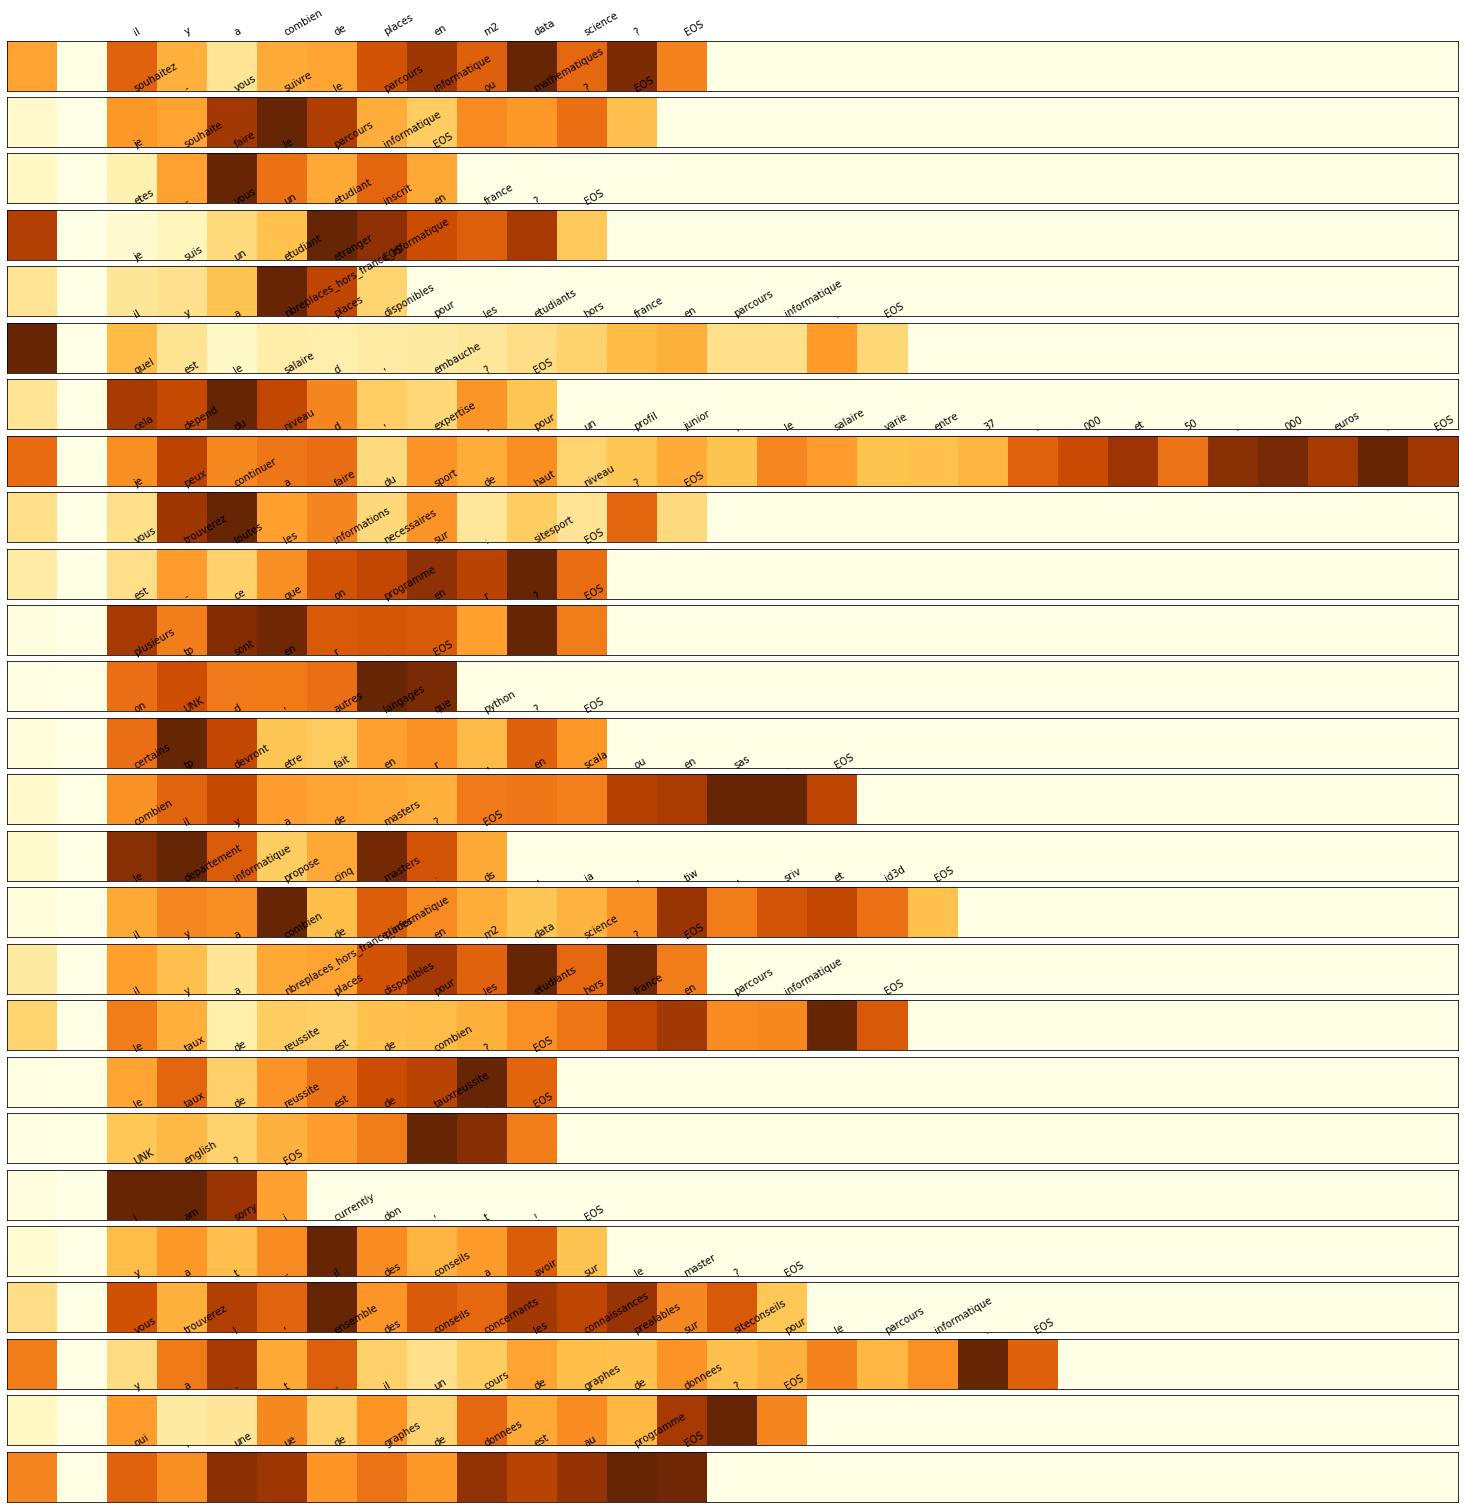

User :  il y a combien de places en m2 data science ?
target :  il y a nbreplaces_hors_france_informatique places disponibles pour les etudiants hors france en parcours informatique .
predic :  le master 2 data science consiste en 6 mois de cours suivis de 4 a 6 mois de stage .


In [34]:
chatbot.eval()
i = 10
dialogue = dialogues_Master_test_var[i][:-3]
chatbot.showAttention(dialogue)

### 6.4.3 Interactive mode

write **quit** or **q** or **eoc** (end of conversation) to close conversation interface :

In [44]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)


def repair(sentence) :
    s = re.sub(" ' ", "'", sentence)
    s = re.sub(" - ", "-", s)
    s = re.sub(" ,", ",", s)
    s = re.sub(r'(?<=\d) \. (?=\d)', '.', s)
    s = re.sub(" \.", ".", s)
    s = re.sub("\( ", "(", s)
    s = re.sub(" \)", ")", s)
    s = s[0].upper() + s[1:]
    return s


def InteractiveEvaluation(agent) :
    agent.initMemory()
    while True :
        text = input()
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse, attn1_weights, attn2_weights = agent(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        reponse = repair(reponse)
        print('Bot  : {}'.format(reponse))

In [45]:
chatbot.eval()
InteractiveEvaluation(chatbot)

combien il y a de places en master data science ?
Bot  : Souhaitez-vous suivre le parcours informatique ou mathematiques ?
mathematiques
Bot  : Etes-vous un etudiant inscrit en france ?
oui
Bot  : Etes-vous un etudiant inscrit a lyon 1 ?
oui
Bot  : Il y a 10 places disponibles pour les etudiants de lyon 1 en parcours informatique.
et mathematiques
Bot  : Le contenu est le meme, seules les ue de remise a niveau sont differentes.
mais le nombre de places
Bot  : D'accord, comment puis-je vous aider ?
quel est le nombre de places ?
Bot  : Les details de la formation est disponible sur la page du master parcours informatique : site_informatique
quit


# 7 Noise filtering

## 7.1 Noisy data generation

In [225]:
cerandom.seed(42)

In [194]:
def randomMask(clean_sentences, rand = 0.2) :
    def choseWord(word) :
        return word if random.random() >= rand else 'UNK'
    masked_sentences = []
    for sentence in clean_sentences :
        words = [choseWord(word) for word in sentence.split()]
        masked_sentences.append(' '.join(words))
    return masked_sentences



def randomNoise(clean_sentences, lang, prop = 1.0):
    noisy_sentences = []
    for sentence in clean_sentences :
        if len(sentence.split()) >= 5 :
            words = [lang.index2word[random.randint(3, lang.n_words-1)] for _ in sentence.split()]
            words = [word for i, word in enumerate(words) if i < 5 or random.random() < prop]
            rand_unk = random.randint(1, len(words)-1)
            words.insert(rand_unk, 'UNK')
            if rand_unk > len(words)/ 2 : words += random.choice(['?', '.'])
            noisy_sentences.append(' '.join(words))
    return noisy_sentences

In [226]:
clean_sentences = [sentence for sentence in list(set([' '.join(pair[0]) for diag in dialogues_Master for pair in diag]))]
print(len(clean_sentences))

masked_sentences_000 = []
masked_sentences_015 = []
masked_sentences_025 = []
noisy_sentences_100 = []
noisy_sentences_050 = []

for _ in range(10) :
    masked_sentences_000 += clean_sentences
    masked_sentences_015 += randomMask(clean_sentences, rand = 0.15)
    masked_sentences_025 += randomMask(clean_sentences, rand = 0.25)

    noisy_sentences_100 += randomNoise(clean_sentences, lang_M2DS, prop = 1.0)
    noisy_sentences_050 += randomNoise(clean_sentences, lang_M2DS, prop = 0.5)

1364


In [227]:
discriminator_dataset = [[sentence, 1] for sentence in masked_sentences_000 + masked_sentences_015 + masked_sentences_025] + \
                        [[sentence, 0] for sentence in noisy_sentences_100 + noisy_sentences_050 + noisy_sentences_020]
random.shuffle(discriminator_dataset)
len(discriminator_dataset)

68199

In [228]:
discriminator_dataset[7][0]

"il y a des projets en cours d ' annee ?"

## 7.2 Noise filtering model

In [46]:
from chatNLP.misc.Noise_Filter import NoiseFilter, NoiseFilterTrainer, NoiseFilterWrapper

In [47]:
noise_filter = NoiseFilter(chatbot, pretrained = True, layers = [100, 50]).to(device)

In [48]:
noise_filter.nbParametres()

25252

In [ ]:
#noise_filter.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_noise_filter.pth'))

In [ ]:
noise_filter_trainer = NoiseFilterTrainer(device,
                                          criterion = nn.NLLLoss(), 
                                          optimizer = optim.SGD)

In [236]:
noise_filter.train()
noise_filter_trainer.train(noise_filter, sentences = discriminator_dataset, n_iters = 20000, learning_rate=0.01)

0m 1s (- 4m 58s) (100 0%) 0.6927 0.54
0m 2s (- 4m 54s) (200 1%) 0.6842 0.44
0m 4s (- 4m 53s) (300 1%) 0.6740 0.42
0m 5s (- 4m 51s) (400 2%) 0.6422 0.38
0m 7s (- 4m 49s) (500 2%) 0.6479 0.43
0m 8s (- 4m 47s) (600 3%) 0.6877 0.55
0m 10s (- 4m 45s) (700 3%) 0.6568 0.48
0m 11s (- 4m 44s) (800 4%) 0.6095 0.40
0m 13s (- 4m 42s) (900 4%) 0.5908 0.43
0m 14s (- 4m 40s) (1000 5%) 0.5977 0.42
0m 16s (- 4m 39s) (1100 5%) 0.6083 0.38
0m 17s (- 4m 38s) (1200 6%) 0.5619 0.33
0m 19s (- 4m 36s) (1300 6%) 0.5956 0.36
0m 20s (- 4m 35s) (1400 7%) 0.5307 0.39
0m 22s (- 4m 33s) (1500 7%) 0.5592 0.31
0m 23s (- 4m 32s) (1600 8%) 0.4890 0.31
0m 25s (- 4m 30s) (1700 8%) 0.4982 0.28
0m 26s (- 4m 29s) (1800 9%) 0.5461 0.27
0m 28s (- 4m 28s) (1900 9%) 0.4971 0.27
0m 29s (- 4m 27s) (2000 10%) 0.3891 0.20
0m 31s (- 4m 26s) (2100 10%) 0.4994 0.24
0m 32s (- 4m 24s) (2200 11%) 0.4825 0.27
0m 34s (- 4m 22s) (2300 11%) 0.5045 0.28
0m 35s (- 4m 21s) (2400 12%) 0.5074 0.26
0m 37s (- 4m 22s) (2500 12%) 0.5052 0.26
0m 38s (-

In [237]:
noise_filter.train()
noise_filter_trainer.train(noise_filter, sentences = discriminator_dataset, n_iters = 10000, learning_rate=0.005)
noise_filter_trainer.train(noise_filter, sentences = discriminator_dataset, n_iters = 10000, learning_rate=0.0025)

0m 1s (- 2m 53s) (100 1%) 0.4419 0.20
0m 3s (- 2m 40s) (200 2%) 0.4527 0.23
0m 4s (- 2m 34s) (300 3%) 0.4322 0.14
0m 6s (- 2m 30s) (400 4%) 0.4354 0.16
0m 7s (- 2m 28s) (500 5%) 0.4906 0.21
0m 9s (- 2m 24s) (600 6%) 0.4737 0.23
0m 10s (- 2m 22s) (700 7%) 0.3436 0.09
0m 12s (- 2m 21s) (800 8%) 0.4129 0.21
0m 13s (- 2m 19s) (900 9%) 0.4146 0.14
0m 15s (- 2m 17s) (1000 10%) 0.4846 0.11
0m 16s (- 2m 15s) (1100 11%) 0.5064 0.23
0m 18s (- 2m 14s) (1200 12%) 0.4950 0.21
0m 19s (- 2m 12s) (1300 13%) 0.4617 0.19
0m 21s (- 2m 10s) (1400 14%) 0.4456 0.15
0m 22s (- 2m 8s) (1500 15%) 0.4615 0.16
0m 24s (- 2m 6s) (1600 16%) 0.3931 0.16
0m 25s (- 2m 4s) (1700 17%) 0.3550 0.13
0m 27s (- 2m 3s) (1800 18%) 0.3953 0.18
0m 28s (- 2m 1s) (1900 19%) 0.4672 0.16
0m 30s (- 2m 0s) (2000 20%) 0.4014 0.21
0m 31s (- 1m 58s) (2100 21%) 0.4186 0.15
0m 33s (- 1m 57s) (2200 22%) 0.4103 0.11
0m 34s (- 1m 56s) (2300 23%) 0.3925 0.15
0m 36s (- 1m 54s) (2400 24%) 0.6133 0.24
0m 37s (- 1m 53s) (2500 25%) 0.3778 0.13
0m 39

In [ ]:
noise_filter.train()
noise_filter_trainer.train(noise_filter, sentences = discriminator_dataset, n_iters = 10000, learning_rate=0.001)

In [240]:
torch.save(noise_filter.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\models\\M2DS_2019_final_noise_filter.pth')

## 7.3 Noise filtering integration

model built on top of a pretrained chatbot model

In [185]:
def SmartInteractiveEvaluation(agent) :
    agent.chatbot.initMemory()
    while True :
        text = input()
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse, attn1_weights, attn2_weights = agent(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        reponse = repair(reponse)
        print('Bot  : {}'.format(reponse))

In [214]:
noise_filter.eval()
smart_chatbot = NoiseFilterWrapper(noise_filter, chatbot)
smart_chatbot.eval()
SmartInteractiveEvaluation(smart_chatbot)

bouf
Bot  : D'accord, comment puis-je vous aider ?
ta gueule
Bot  : D'accord, comment puis-je vous aider ?
c"est pas beau de mentir
Bot  : C'est dommage, vous en aurez besoin si vous souhaitez faire ce master.
haaaa mais tu comprends rien
Bot  : Je n'ai pas compris, merci de reformuler la question
quit
